In [17]:
import pandas as pd

# Configuração para exibir todas as colunas no DataFrame
pd.set_option("display.max_columns", None)

train_path = r"C:\Users\diogo\Downloads\train_data_prepared.feather"
test_path = r"C:\Users\diogo\Downloads\test_data_prepared.feather"
df = pd.read_feather(train_path)
df_test = pd.read_feather(test_path)

df.shape, df_test.shape

((19212, 2401), (4804, 2401))

In [ ]:
from sklearn.model_selection import train_test_split

X_train = df.drop(columns=["swarm_behaviour"])
y_train = df["swarm_behaviour"].ravel()

X_test = df_test.drop(columns=["swarm_behaviour"])
y_test = df_test["swarm_behaviour"].ravel()

print(f"Tamanho do Treino: {X_train.shape}")

Tamanho do Treino: (19212, 2400)


C:\Users\diogo\AppData\Local\Temp\ipykernel_20048\3422019558.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = df["swarm_behaviour"].ravel()
C:\Users\diogo\AppData\Local\Temp\ipykernel_20048\3422019558.py:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test = df_test["swarm_behaviour"].ravel()


In [ ]:
print("Resumo do conjunto de treino:")
print(df.describe())  # Estatísticas gerais
print("\nDistribuição das classes:")
print(df["swarm_behaviour"].value_counts(normalize=True))  # Verifica balanceamento

In [20]:
from sklearn.decomposition import PCA

# 2. Aplicar PCA, garantindo que pelo menos 95% da variância seja explicada
pca = PCA(n_components=0.90)  # 90%
X_train_pca = pca.fit_transform(X_train)

# 3. Transformar os dados de teste usando o PCA ajustado nos dados de treino
x_test_pca = pca.transform(X_test)

# 4. Verificar a variância explicada
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Variância explicada: {explained_variance:.2%}")

Variância explicada: 90.00%


In [21]:
print(X_train_pca.shape, y_train.shape, y_test.shape)

(19212, 317) (19212,) (4804,)


In [22]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier,
    BaggingClassifier,
)
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import loguniform, randint, uniform
from time import time

try:
    SAVE_DIR = "experimentos_ml/"
except ImportError:
    SAVE_DIR = "resultados_experimentos/"

# Criar diretório para salvar os resultados
os.makedirs(SAVE_DIR, exist_ok=True)


class ModelSelection:
    def __init__(self, models, param_distributions, metric="accuracy", random_state=42):
        self.models = models
        self.param_distributions = param_distributions
        self.metric = metric
        self.random_state = random_state
        self.save_dir = SAVE_DIR  # Diretório definido no início
        os.makedirs(self.save_dir, exist_ok=True)

    def evaluate_models(self, X_train, y_train, model_names, cv=5, n_iter=20):
        """Treina e avalia modelos com RandomizedSearchCV"""
        y_train = y_train.ravel()
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=self.random_state)

        for name in model_names:
            if name not in self.models:
                print(f"⚠️ Modelo {name} não encontrado!")
                continue
            start_time = time()

            print(f"🔹 Avaliando {name} com RandomizedSearchCV...")
            model = self.models[name]
            param_dist = self.param_distributions[name]

            random_search = RandomizedSearchCV(
                estimator=model,
                param_distributions=param_dist,
                n_iter=n_iter,
                cv=skf,
                scoring=self.metric,
                n_jobs=-1,
                random_state=self.random_state,
                return_train_score=True,
            )

            random_search.fit(X_train, y_train)

            best_params = random_search.best_params_
            best_estimator = random_search.best_estimator_
            best_cv_accuracy = random_search.best_score_
            std_cv_accuracy = np.std(random_search.cv_results_["mean_test_score"])

            y_pred = best_estimator.predict(X_train)
            y_pred_proba = (
                best_estimator.predict_proba(X_train)
                if hasattr(best_estimator, "predict_proba")
                else None
            )

            accuracy = accuracy_score(y_train, y_pred)
            precision = precision_score(y_train, y_pred, average="weighted")
            recall = recall_score(y_train, y_pred, average="weighted")
            f1 = f1_score(y_train, y_pred, average="weighted")

            roc_auc = None
            if y_pred_proba is not None:
                try:
                    if y_pred_proba.shape[1] == 2:
                        roc_auc = roc_auc_score(y_train, y_pred_proba[:, 1])
                    else:
                        roc_auc = roc_auc_score(
                            y_train, y_pred_proba, multi_class="ovr"
                        )
                except ValueError:
                    print(f"Erro ao calcular AUC-ROC para {name}. Definindo como None.")
            end_time = time()
            total_time = end_time - start_time
            results = {
                "Modelo": name,
                "Melhores Hiperparâmetros": {
                    k: str(v) for k, v in best_params.items()
                },  # Convertendo para string para melhor legibilidade
                "Acurácia (CV)": round(best_cv_accuracy, 4),
                "Desvio-Padrão (CV)": round(std_cv_accuracy, 4),
                "Precisão": round(precision, 4),
                "Recall": round(recall, 4),
                "F1-score": round(f1, 4),
                "AUC-ROC": round(roc_auc, 4) if roc_auc is not None else None,
                "Tempo de Execução (s)": round(
                    total_time, 2
                ),  # Arredondamento para evitar valores grandes
            }
             # Salvando todas as iterações para análise posterior
            all_iterations = {
                "rank_test_score": random_search.cv_results_["rank_test_score"].tolist(),
                "mean_test_score": random_search.cv_results_["mean_test_score"].tolist(),
                "std_test_score": random_search.cv_results_["std_test_score"].tolist(),
                "mean_train_score": random_search.cv_results_.get("mean_train_score", []).tolist(),
            }

            results = {
                "Modelo": name,
                "Melhores Hiperparâmetros": {k: str(v) for k, v in best_params.items()},
                "Acurácia (CV)": round(best_cv_accuracy, 4),
                "Desvio-Padrão (CV)": round(std_cv_accuracy, 4),
                "Precisão": round(precision, 4),
                "Recall": round(recall, 4),
                "F1-score": round(f1, 4),
                "AUC-ROC": round(roc_auc, 4) if roc_auc is not None else None,
                "Tempo de Execução (s)": round(total_time, 2),
                "Iterações": all_iterations  # Incluindo todas as iterações para análise de distribuição
            }

            # 📂 Salvar resultados do modelo
            print(results)
            save_path = os.path.join(self.save_dir, f"{name}_results.json")
            with open(save_path, "w") as f:
                json.dump(results, f, indent=4)
            print(f"✅ Resultados de {name} salvos em {save_path}")

            # 📊 Gerar gráficos individuais
            self.plot_search_results(name, random_search.cv_results_)
            self.plot_confusion_matrix(y_train, y_pred, name)
            if y_pred_proba is not None:
                self.plot_roc_curve(y_train, y_pred_proba, name)

    def plot_search_results(self, model_name, search_results):
        """Plota a evolução da busca de hiperparâmetros"""
        plt.figure(figsize=(10, 6))
        plt.plot(search_results["mean_test_score"], label="Média CV")
        plt.fill_between(
            range(len(search_results["mean_test_score"])),
            search_results["mean_test_score"] - search_results["std_test_score"],
            search_results["mean_test_score"] + search_results["std_test_score"],
            alpha=0.2,
        )
        plt.xlabel("Iteração")
        plt.ylabel("Score")
        plt.title(f"Evolução da Busca - {model_name}")
        plt.legend()
        plt.savefig(os.path.join(self.save_dir, f"{model_name}_search_results.png"))
        plt.show()

    def compare_models(self):
        """Compara o desempenho dos modelos lendo os JSONs salvos"""
        all_results = []
        for filename in os.listdir(self.save_dir):
            if filename.endswith("_results.json"):
                try:
                    with open(os.path.join(self.save_dir, filename), "r") as f:
                        all_results.append(json.load(f))
                except Exception as e:
                    print(f"Erro ao carregar {filename}: {e}")

        if not all_results:
            print("⚠️ Nenhum resultado encontrado para comparação!")
            return

        df_results = pd.DataFrame(all_results)

        plt.figure(figsize=(12, 8))
        df_results.plot(
            x="Modelo",
            y=["Acurácia (CV)", "Precisão", "Recall", "F1-score", "AUC-ROC"],
            kind="bar",
        )
        plt.title("Comparação de Desempenho entre Modelos")
        plt.ylabel("Valor")
        plt.xlabel("Modelo")
        plt.xticks(rotation=45)
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
        plt.show()

    def test_best_model(self, X_test, y_test):
        y_pred = self.best_model.predict(X_test)
        y_pred_proba = (
            self.best_model.predict_proba(X_test)[:, 1]
            if hasattr(self.best_model, "predict_proba")
            else None
        )

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted")
        recall = recall_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="weighted")
        roc_auc = (
            roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
        )

        print(f"Acurácia: {accuracy:.4f}")
        print(f"Precisão: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        if roc_auc is not None:
            print(f"AUC-ROC: {roc_auc:.4f}")

        self.plot_confusion_matrix(y_test, y_pred)
        if y_pred_proba is not None:
            self.plot_roc_curve(y_test, y_pred_proba)

    def check_overfitting(self, X_train, y_train, X_test, y_test):
        """Compara as métricas de treino e teste para verificar overfitting"""
        y_train_pred = self.best_model.predict(X_train)
        y_test_pred = self.best_model.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        print(f"Acurácia no Treino: {train_acc:.4f}")
        print(f"Acurácia no Teste: {test_acc:.4f}")
        print(f"Gap de Acurácia: {abs(train_acc - test_acc):.4f}")

    def plot_roc_curve(self, y_true, y_pred_proba, model_name):
        """Plota a curva ROC."""
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 6))
        plt.plot(
            fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})"
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {model_name}")
        plt.legend(loc="lower right")
        plt.savefig(f"{self.save_dir}/{model_name}_roc_curve.png")
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, model_name):
        """Plota a matriz de confusão."""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Matriz de Confusão - {model_name}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.savefig(f"{self.save_dir}/{model_name}_conf_matrix.png")
        plt.show()

    def find_best_model(self, X_val, y_val):
        """
        Encontra o melhor modelo no conjunto de validação, baseado na métrica de interesse.

        Retorna:
        - O nome do melhor modelo
        - O modelo treinado com os melhores hiperparâmetros
        """
        best_model_name = None
        best_model = None
        best_score = -np.inf

        best_hyperparams = self.select_best_hyperparameters()

        for model_name, best_params in best_hyperparams.items():
            try:
                print(f"🔹 Avaliando {model_name} no conjunto de validação...")

                # Criar modelo com os melhores hiperparâmetros
                model = self.models[model_name].set_params(**best_params)

                # Treinar o modelo com os dados de treino reduzidos (X_train_pca)
                model.fit(X_train_pca, y_train)

                # Avaliação no conjunto de validação
                y_val_pred = model.predict(X_val)
                score = f1_score(
                    y_val, y_val_pred, average="weighted"
                )  # Pode ser alterado para outra métrica

                print(f"🔹 {model_name} - F1-score na validação: {score:.4f}")

                # Verificar se esse modelo é o melhor
                if score > best_score:
                    best_score = score
                    best_model_name = model_name
                    best_model = model

            except Exception as e:
                print(f"⚠️ Erro ao avaliar {model_name}: {e}")

        print(
            f"\n✅ Melhor modelo encontrado: {best_model_name} com F1-score de {best_score:.4f}"
        )
        return best_model_name, best_model

    def train_best_model_final(
        self, best_model_name, X_train_full, y_train_full, X_test, y_test
    ):
        """
        Treina o melhor modelo encontrado com a base de treino completa e avalia no conjunto de teste.

        Retorna:
        - O modelo final treinado
        - As métricas no conjunto de teste
        """
        best_hyperparams = self.select_best_hyperparameters()

        if best_model_name not in best_hyperparams:
            print(f"⚠️ Não foi possível encontrar hiperparâmetros para {best_model_name}.")
            return None, None

        try:
            print(
                f"🔹 Treinando modelo final {best_model_name} com todos os dados de treino..."
            )

            # Criar modelo com os melhores hiperparâmetros
            final_model = self.models[best_model_name].set_params(
                **best_hyperparams[best_model_name]
            )

            # Treinar com 100% dos dados de treino
            final_model.fit(X_train_full, y_train_full)

            # Avaliação no conjunto de teste
            y_test_pred = final_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_test_pred)
            precision = precision_score(y_test, y_test_pred, average="weighted")
            recall = recall_score(y_test, y_test_pred, average="weighted")
            f1 = f1_score(y_test, y_test_pred, average="weighted")

            print(f"\n✅ Avaliação Final no Conjunto de Teste:")
            print(f"Acurácia: {accuracy:.4f}")
            print(f"Precisão: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1-score: {f1:.4f}")

            return final_model, {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1_score": f1,
            }

        except Exception as e:
            print(f"⚠️ Erro ao treinar modelo final {best_model_name}: {e}")
            return None, None

🔹 Avaliando Árvore de Decisão com RandomizedSearchCV...
{'Modelo': 'Árvore de Decisão', 'Melhores Hiperparâmetros': {'criterion': 'entropy', 'max_depth': '10', 'min_samples_leaf': '1', 'min_samples_split': '13'}, 'Acurácia (CV)': np.float64(0.9994), 'Desvio-Padrão (CV)': np.float64(0.0015), 'Precisão': 0.9999, 'Recall': 0.9999, 'F1-score': 0.9999, 'AUC-ROC': np.float64(1.0), 'Tempo de Execução (s)': 70.89, 'Iterações': {'rank_test_score': [20, 6, 8, 3, 1, 11, 17, 19, 15, 13, 9, 14, 7, 10, 2, 3, 5, 12, 16, 18], 'mean_test_score': [0.9943265898651157, 0.9984384894728722, 0.9980742178393675, 0.9992712806385672, 0.999375379534279, 0.997917981448588, 0.9959401159757872, 0.9947949197571576, 0.9975016671400898, 0.9978139367357756, 0.9980741094735684, 0.9976576732535463, 0.9982302781357235, 0.9980221616186491, 0.9993233233135607, 0.9992712806385672, 0.9991671817428553, 0.9978659252278697, 0.9967208509207637, 0.9949512103308367], 'std_test_score': [0.0016240796650731247, 0.00036798775944243744,

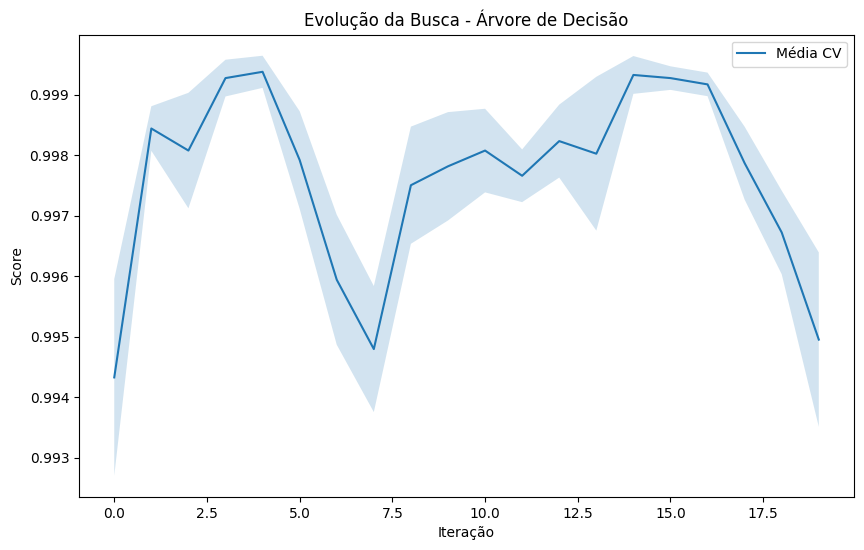

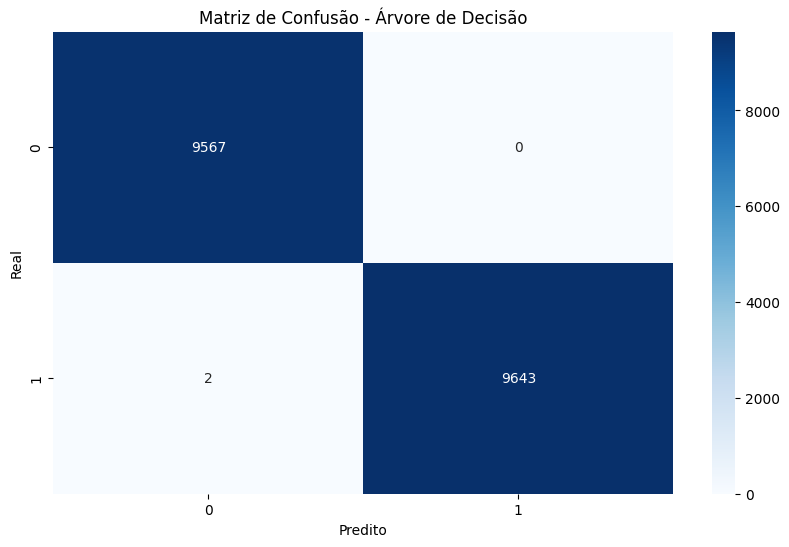

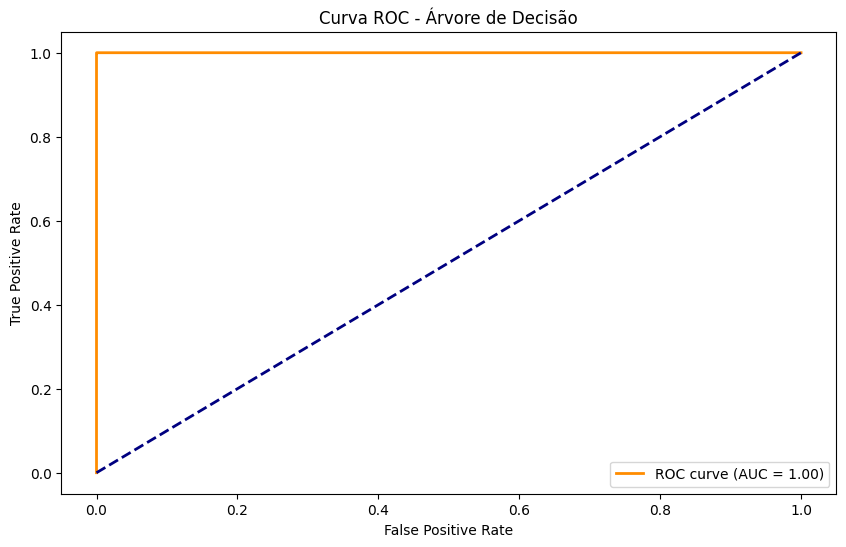

🔹 Avaliando KNN com RandomizedSearchCV...


c:\Users\diogo\Repositorios\web_scraping\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\diogo\Repositorios\web_scraping\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\diogo\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\diogo\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, in _

{'Modelo': 'KNN', 'Melhores Hiperparâmetros': {'n_neighbors': '3', 'p': '2', 'weights': 'uniform'}, 'Acurácia (CV)': np.float64(0.9998), 'Desvio-Padrão (CV)': np.float64(0.0001), 'Precisão': 0.9999, 'Recall': 0.9999, 'F1-score': 0.9999, 'AUC-ROC': np.float64(1.0), 'Tempo de Execução (s)': 539.23, 'Iterações': {'rank_test_score': [8, 9, 9, 5, 5, 9, 1, 3, 9, 9, 9, 5, 9, 9, 20, 19, 1, 3, 9, 9], 'mean_test_score': [0.9996356335464212, 0.9996356200006963, 0.9996356200006963, 0.9996876762214146, 0.9996876762214146, 0.9996356200006963, 0.9998438448835698, 0.9997917886628513, 0.9996356200006963, 0.9996356200006963, 0.9996356200006963, 0.9996876762214146, 0.9996356200006963, 0.9996356200006963, 0.9995315211049844, 0.9995835773257028, 0.9998438448835698, 0.9997917886628513, 0.9996356200006963, 0.9996356200006963], 'std_test_score': [0.00020823843080122748, 0.0002654409996466499, 0.0002654409996466499, 0.0002550251238289361, 0.0002550251238289361, 0.0002654409996466499, 0.0001275001210581917, 0.0

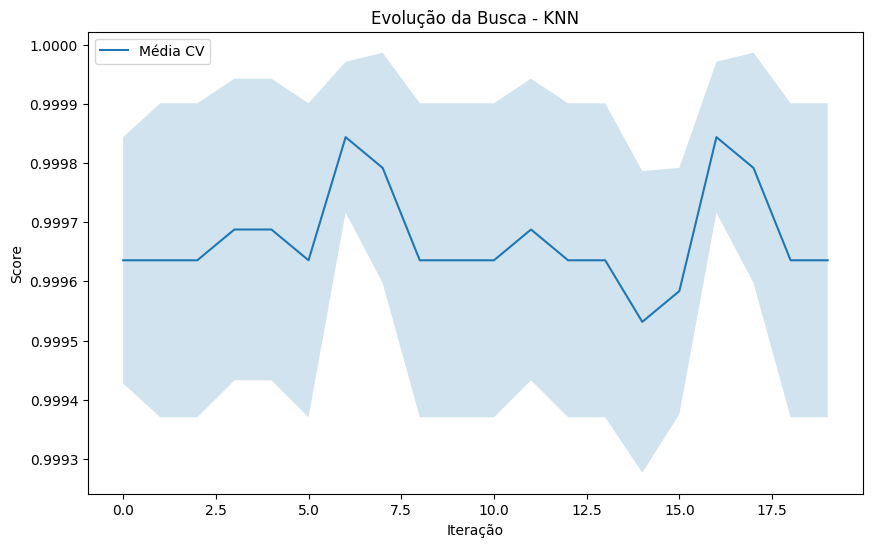

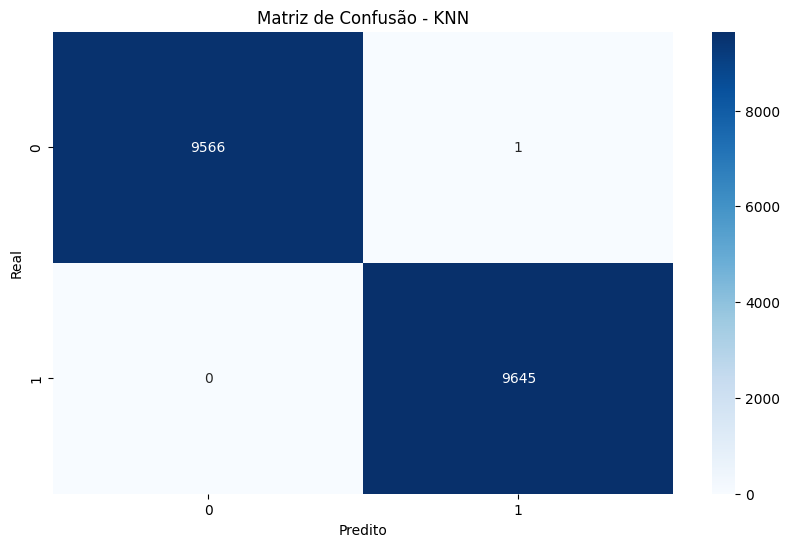

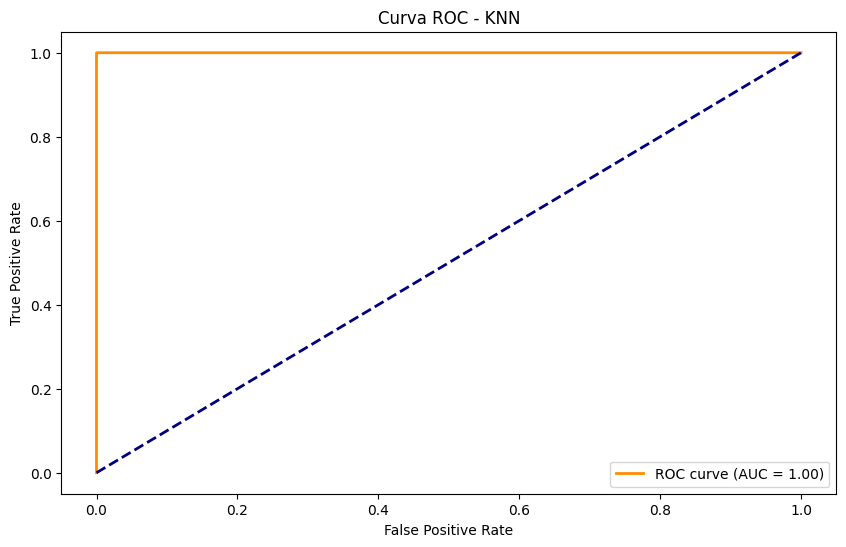

🔹 Avaliando LVQ com RandomizedSearchCV...
{'Modelo': 'LVQ', 'Melhores Hiperparâmetros': {'alpha': '0.005262961031076741', 'hidden_layer_sizes': '(5,)'}, 'Acurácia (CV)': np.float64(0.9999), 'Desvio-Padrão (CV)': np.float64(0.0), 'Precisão': 0.9998, 'Recall': 0.9998, 'F1-score': 0.9998, 'AUC-ROC': np.float64(1.0), 'Tempo de Execução (s)': 30.13, 'Iterações': {'rank_test_score': [9, 9, 16, 9, 9, 2, 2, 9, 16, 16, 16, 2, 2, 9, 2, 9, 2, 1, 16, 2], 'mean_test_score': [0.9997917886628513, 0.9997917886628513, 0.999739732442133, 0.9997917886628513, 0.9997917886628513, 0.9998438448835698, 0.9998438448835698, 0.9997917886628513, 0.999739732442133, 0.999739732442133, 0.999739732442133, 0.9998438448835698, 0.9998438448835698, 0.9997917886628513, 0.9998438448835698, 0.9997917886628513, 0.9998438448835698, 0.9998959011042882, 0.999739732442133, 0.9998438448835698], 'std_test_score': [0.00010410567187901195, 0.00010410567187901195, 0.00028512366474629715, 0.00019477292438166186, 0.00019477292438166186

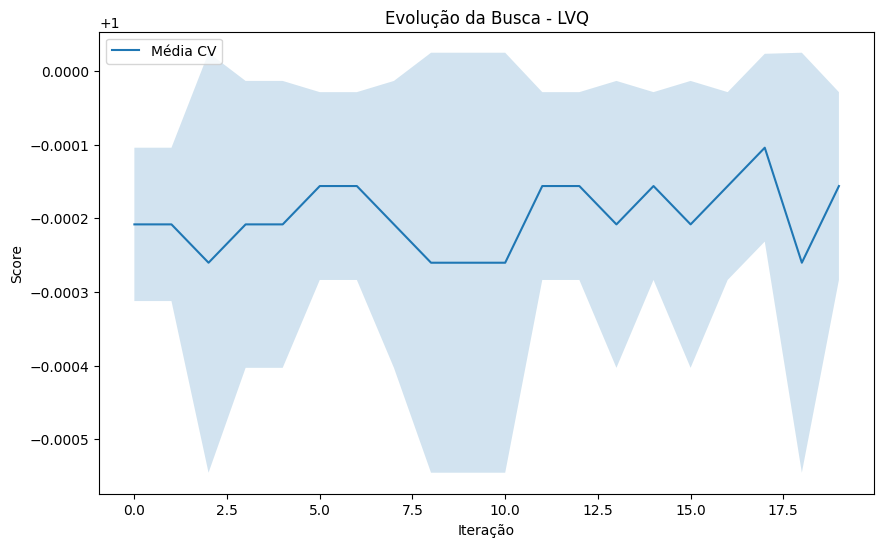

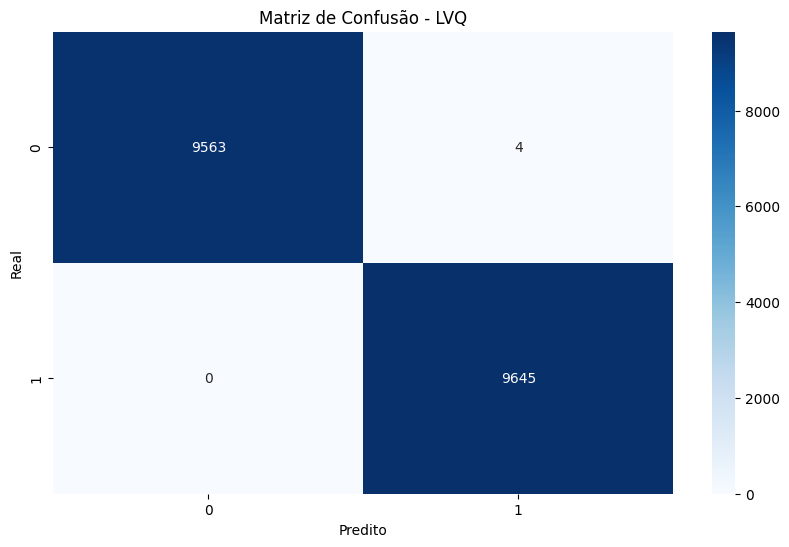

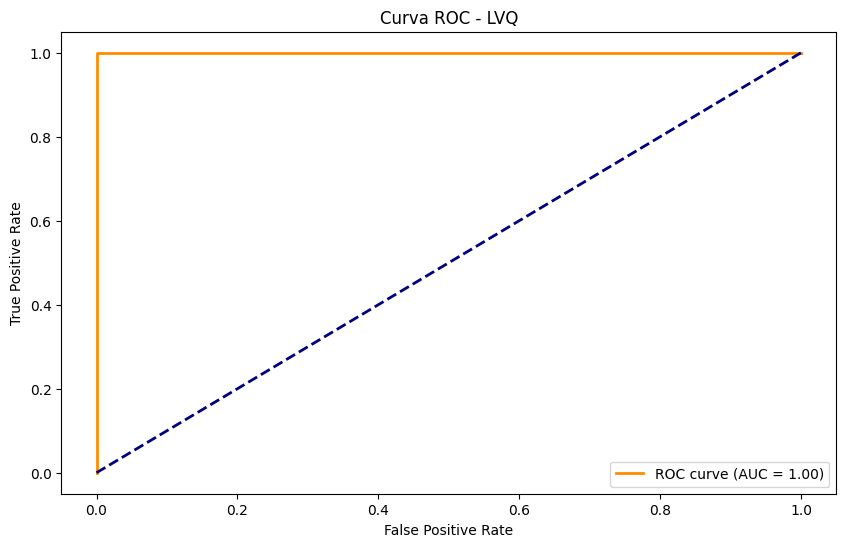

🔹 Avaliando SVM com RandomizedSearchCV...
{'Modelo': 'SVM', 'Melhores Hiperparâmetros': {'C': '0.10051981180656774', 'gamma': 'auto', 'kernel': 'linear'}, 'Acurácia (CV)': np.float64(0.9999), 'Desvio-Padrão (CV)': np.float64(0.0007), 'Precisão': 0.9999, 'Recall': 0.9999, 'F1-score': 0.9999, 'AUC-ROC': np.float64(1.0), 'Tempo de Execução (s)': 252.72, 'Iterações': {'rank_test_score': [2, 13, 3, 3, 13, 1, 3, 13, 19, 13, 13, 3, 3, 3, 13, 20, 3, 3, 3, 3], 'mean_test_score': [0.9998438448835698, 0.9996876762214146, 0.9997917886628513, 0.9997917886628513, 0.9996876762214146, 0.9998959011042882, 0.9997917886628513, 0.9996876762214146, 0.9994795326128905, 0.9996876762214146, 0.9996876762214146, 0.9997917886628513, 0.9997917886628513, 0.9997917886628513, 0.9996876762214146, 0.9967731509645301, 0.9997917886628513, 0.9997917886628513, 0.9997917886628513, 0.9997917886628513], 'std_test_score': [0.0001275001210581917, 0.0002550251238289361, 0.00019477292438166186, 0.00019477292438166186, 0.00025502

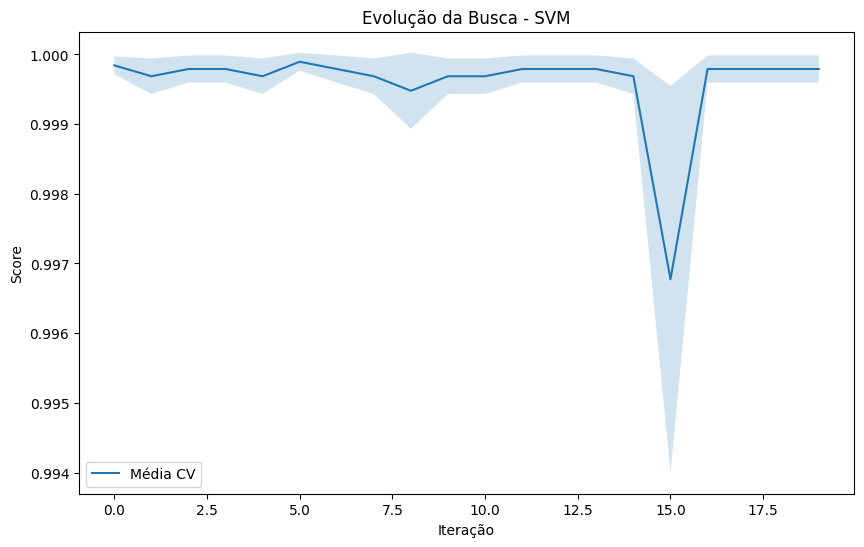

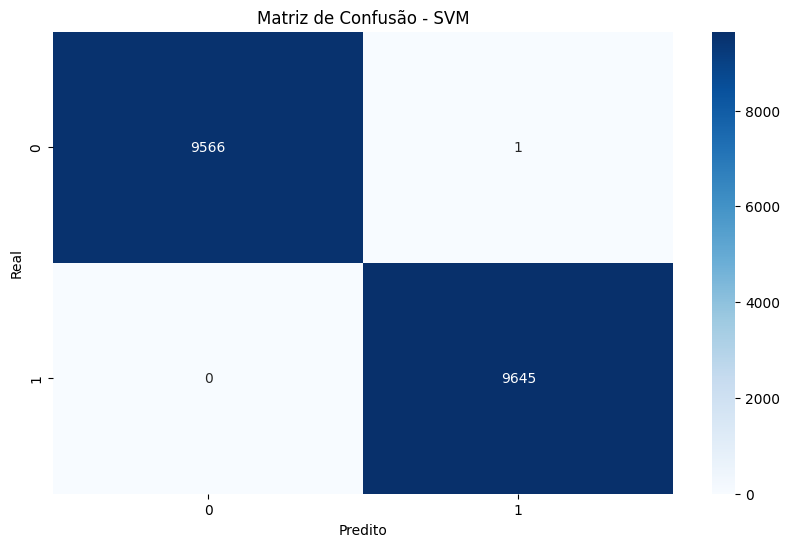

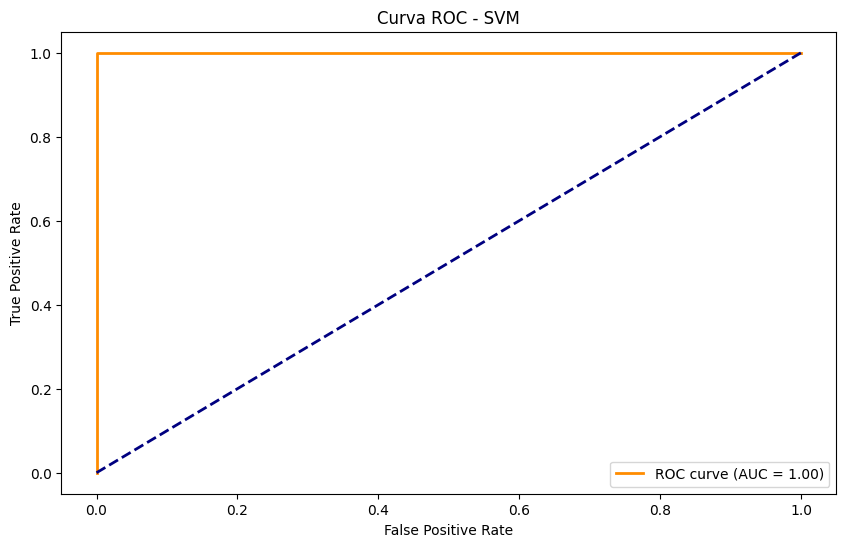

🔹 Avaliando Random Forest com RandomizedSearchCV...
{'Modelo': 'Random Forest', 'Melhores Hiperparâmetros': {'criterion': 'gini', 'max_depth': '13', 'min_samples_leaf': '8', 'min_samples_split': '6', 'n_estimators': '50'}, 'Acurácia (CV)': np.float64(0.9999), 'Desvio-Padrão (CV)': np.float64(0.0014), 'Precisão': 0.9999, 'Recall': 0.9999, 'F1-score': 0.9999, 'AUC-ROC': np.float64(1.0), 'Tempo de Execução (s)': 197.35, 'Iterações': {'rank_test_score': [12, 1, 1, 12, 16, 1, 1, 1, 1, 12, 17, 19, 1, 1, 1, 1, 18, 1, 12, 20], 'mean_test_score': [0.9998438448835698, 0.9998959011042882, 0.9998959011042882, 0.9998438448835698, 0.9997917886628513, 0.9998959011042882, 0.9998959011042882, 0.9998959011042882, 0.9998959011042882, 0.9998438448835698, 0.999739732442133, 0.99786587104497, 0.9998959011042882, 0.9998959011042882, 0.9998959011042882, 0.9998959011042882, 0.9980219448870511, 0.9998959011042882, 0.9998438448835698, 0.9937012921131508], 'std_test_score': [0.0001275001210581917, 0.0001274945904

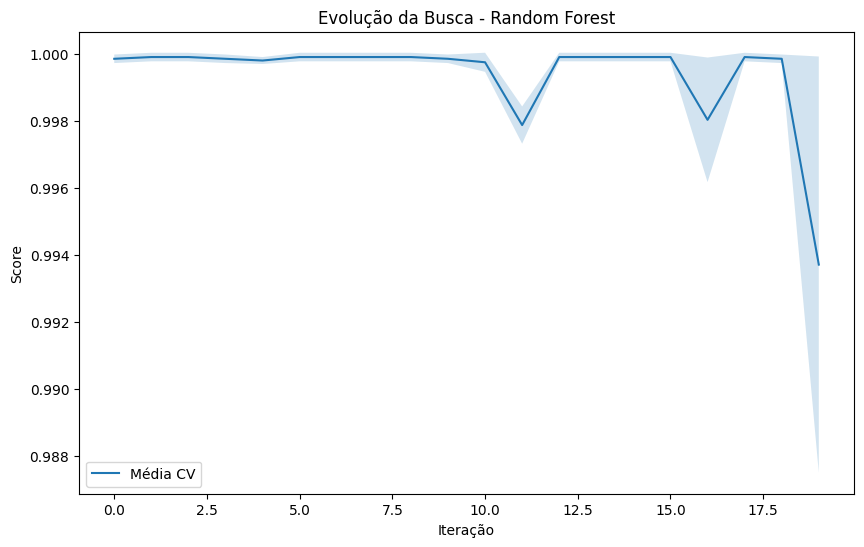

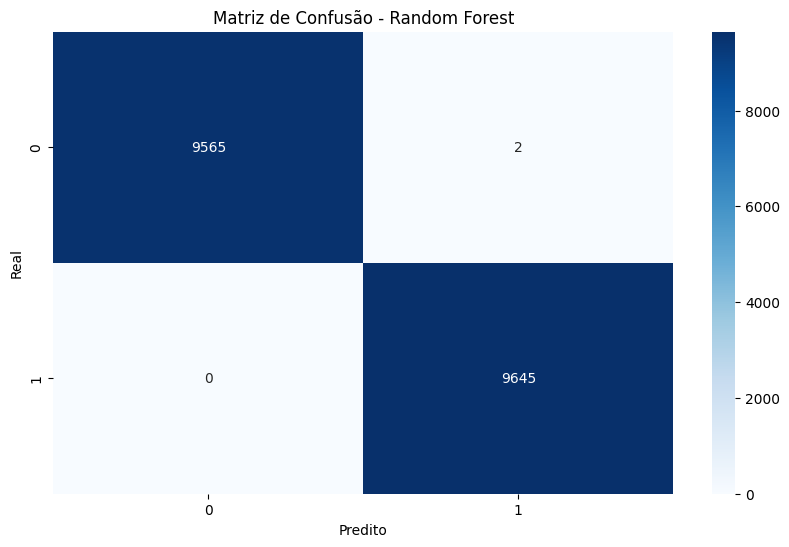

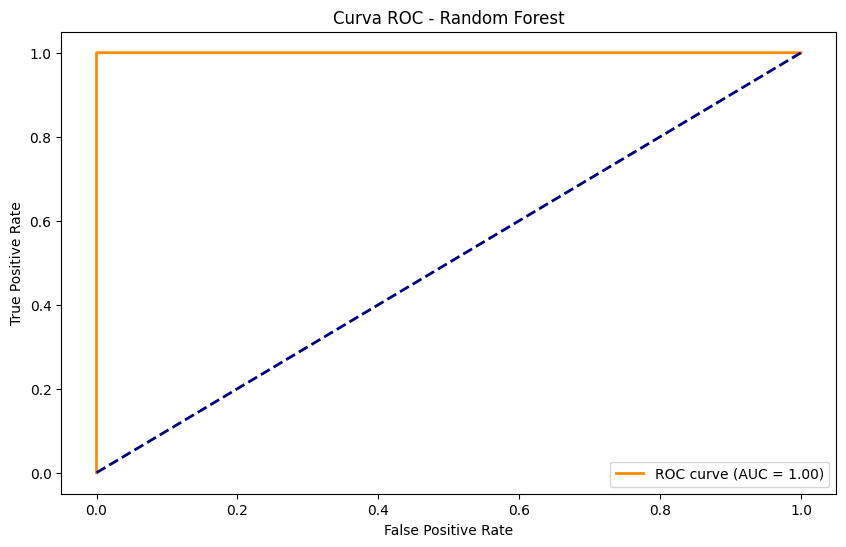

🔹 Avaliando MLP (Rede Neural) com RandomizedSearchCV...
{'Modelo': 'MLP (Rede Neural)', 'Melhores Hiperparâmetros': {'activation': 'relu', 'alpha': '0.0005611516415334506', 'hidden_layer_sizes': '(50,)', 'learning_rate': 'constant', 'max_iter': '200'}, 'Acurácia (CV)': np.float64(0.9999), 'Desvio-Padrão (CV)': np.float64(0.0), 'Precisão': 0.9999, 'Recall': 0.9999, 'F1-score': 0.9999, 'AUC-ROC': np.float64(1.0), 'Tempo de Execução (s)': 58.85, 'Iterações': {'rank_test_score': [1, 4, 14, 14, 19, 4, 1, 4, 14, 4, 19, 4, 4, 14, 1, 4, 4, 4, 4, 14], 'mean_test_score': [0.9998958875585633, 0.9998438313378448, 0.9997917886628513, 0.9997917886628513, 0.999739732442133, 0.9998438313378448, 0.9998958875585633, 0.9998438313378448, 0.9997917886628513, 0.9998438313378448, 0.999739732442133, 0.9998438313378448, 0.9998438313378448, 0.9997917886628513, 0.9998958875585633, 0.9998438313378448, 0.9998438313378448, 0.9998438313378448, 0.9998438313378448, 0.9997917886628513], 'std_test_score': [0.00020822488

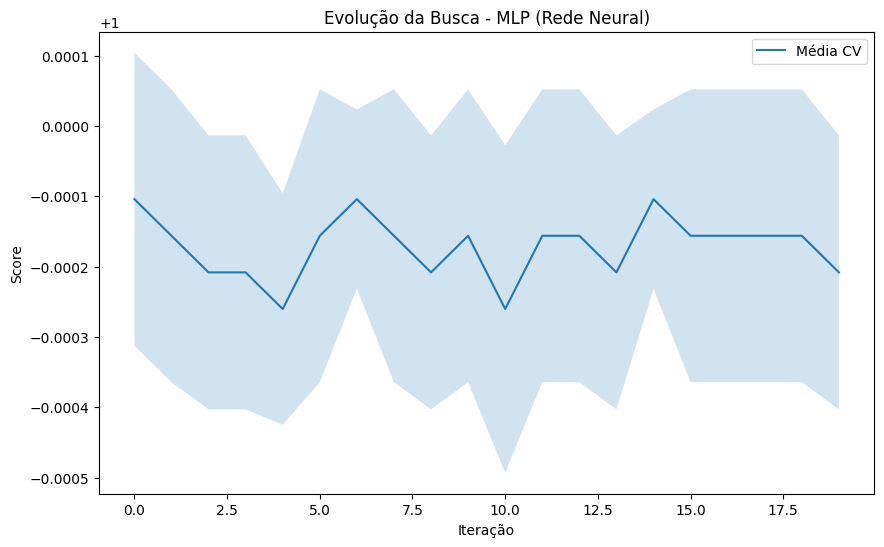

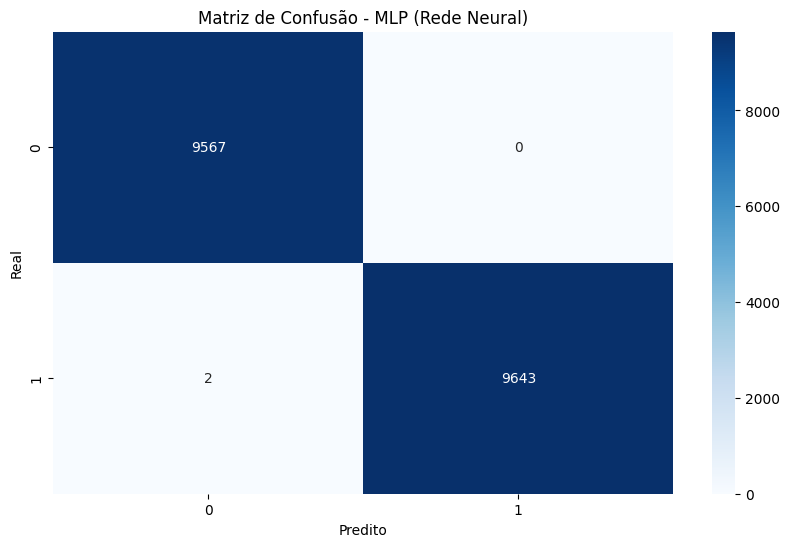

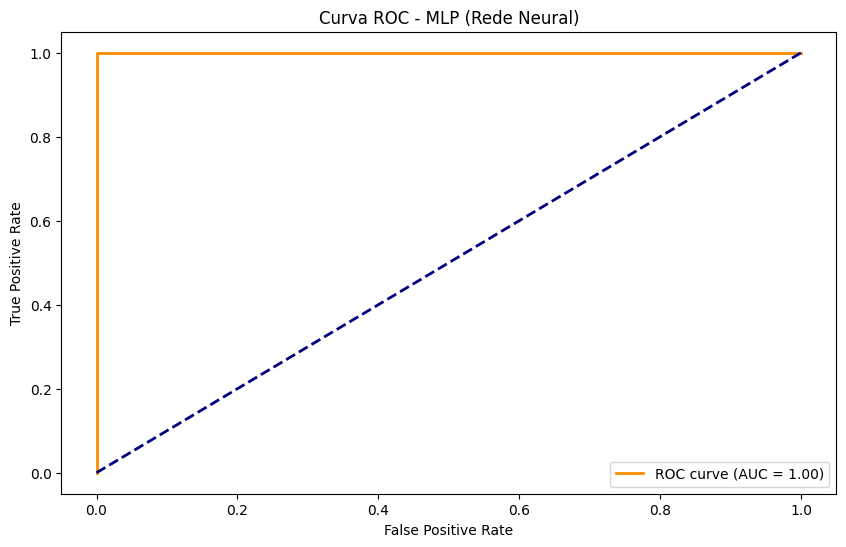

🔹 Avaliando LightGBM com RandomizedSearchCV...


c:\Users\diogo\Repositorios\web_scraping\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\diogo\Repositorios\web_scraping\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


{'Modelo': 'LightGBM', 'Melhores Hiperparâmetros': {'colsample_bytree': '0.6362425738131283', 'learning_rate': '0.03402648808424155', 'max_depth': '14', 'n_estimators': '84', 'subsample': '0.9932923543227152'}, 'Acurácia (CV)': np.float64(0.9999), 'Desvio-Padrão (CV)': np.float64(0.0068), 'Precisão': 0.9999, 'Recall': 0.9999, 'F1-score': 0.9999, 'AUC-ROC': np.float64(1.0), 'Tempo de Execução (s)': 87.98, 'Iterações': {'rank_test_score': [3, 9, 4, 18, 16, 14, 1, 6, 1, 9, 20, 15, 4, 12, 17, 13, 19, 9, 8, 6], 'mean_test_score': [0.9998958875585633, 0.9996876762214146, 0.9998438448835698, 0.9968250175451002, 0.9983864467978787, 0.999479478429991, 0.9998959011042882, 0.9997917886628513, 0.9998959011042882, 0.9996876762214146, 0.9685617542147185, 0.9992192379635736, 0.9998438448835698, 0.9996356606378709, 0.9982302645899986, 0.9995315346507093, 0.9966167520250521, 0.9996876762214146, 0.9997397459878579, 0.9997917886628513], 'std_test_score': [0.0001275111786977222, 0.0002550251238289361, 0.0

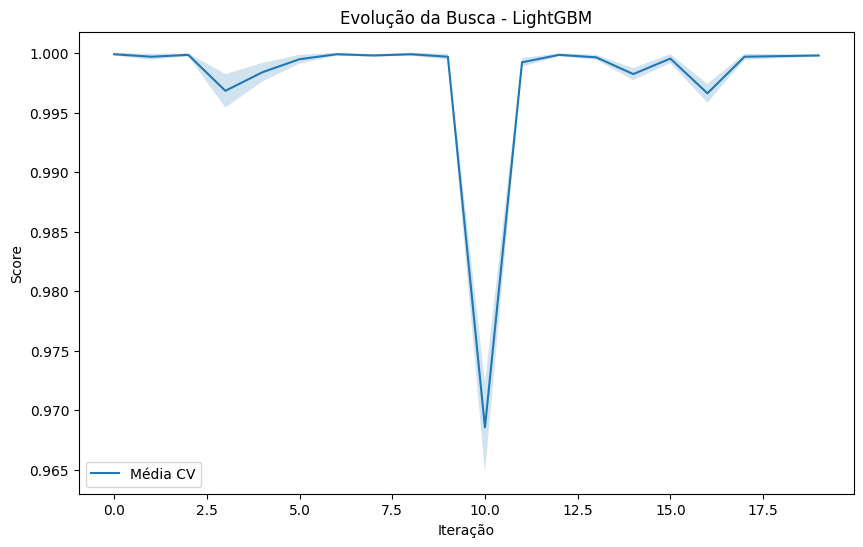

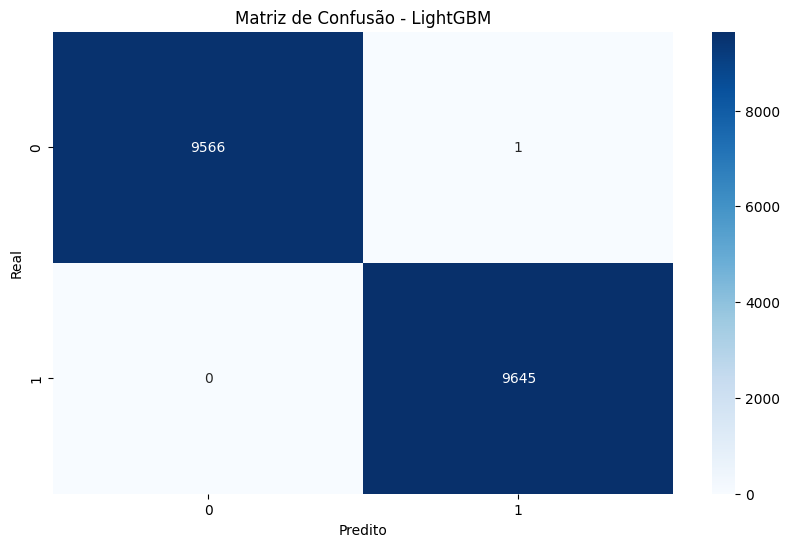

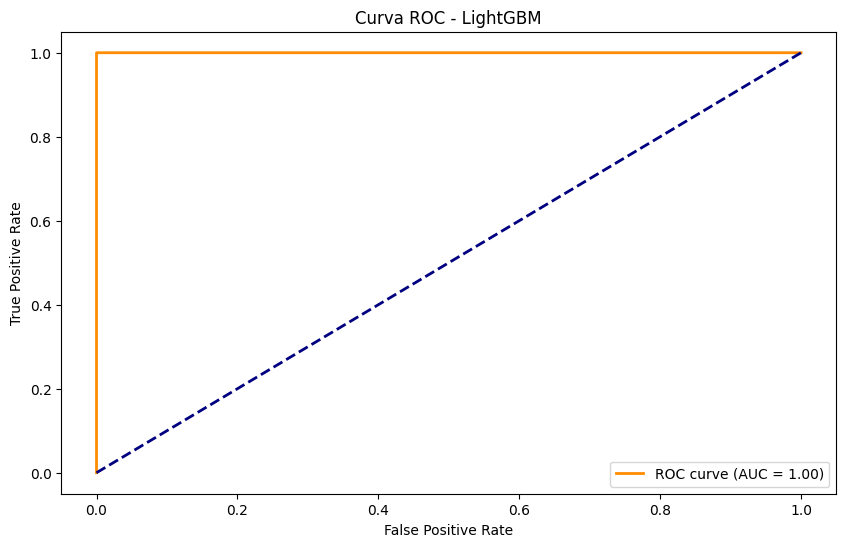

🔹 Avaliando XGBoost com RandomizedSearchCV...
{'Modelo': 'XGBoost', 'Melhores Hiperparâmetros': {'colsample_bytree': '0.5780093202212182', 'learning_rate': '0.0029375384576328283', 'max_depth': '13', 'n_estimators': '252', 'subsample': '0.9330880728874675'}, 'Acurácia (CV)': np.float64(0.9999), 'Desvio-Padrão (CV)': np.float64(0.0016), 'Precisão': 0.9999, 'Recall': 0.9999, 'F1-score': 0.9999, 'AUC-ROC': np.float64(1.0), 'Tempo de Execução (s)': 170.68, 'Iterações': {'rank_test_score': [5, 1, 8, 20, 1, 8, 5, 12, 1, 13, 17, 8, 5, 1, 18, 13, 8, 18, 16, 15], 'mean_test_score': [0.9998958875585633, 0.9998959011042882, 0.9998438448835698, 0.992400726430134, 0.9998959011042882, 0.9998438448835698, 0.9998958875585633, 0.9998438313378448, 0.9998959011042882, 0.999739732442133, 0.9992192650550233, 0.9998438448835698, 0.9998958875585633, 0.9998959011042882, 0.999167208834305, 0.999739732442133, 0.9998438448835698, 0.999167208834305, 0.9995835773257028, 0.9996356335464212], 'std_test_score': [0.00

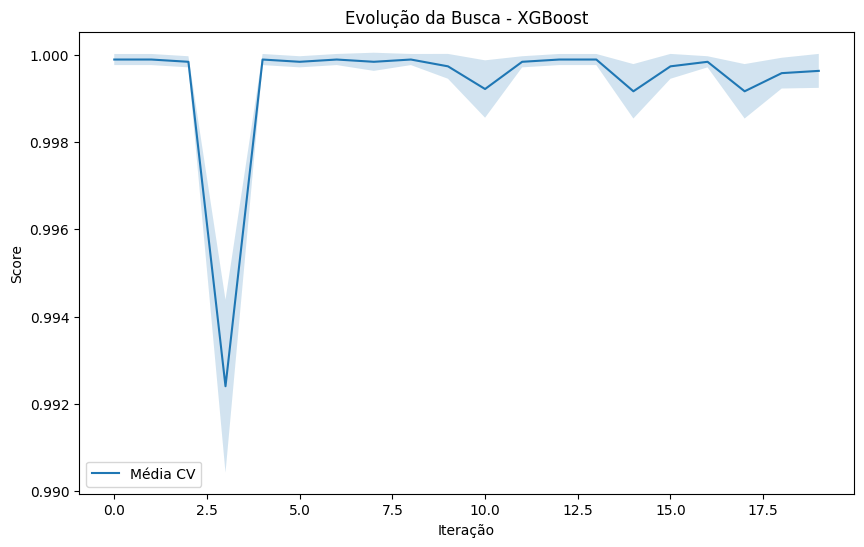

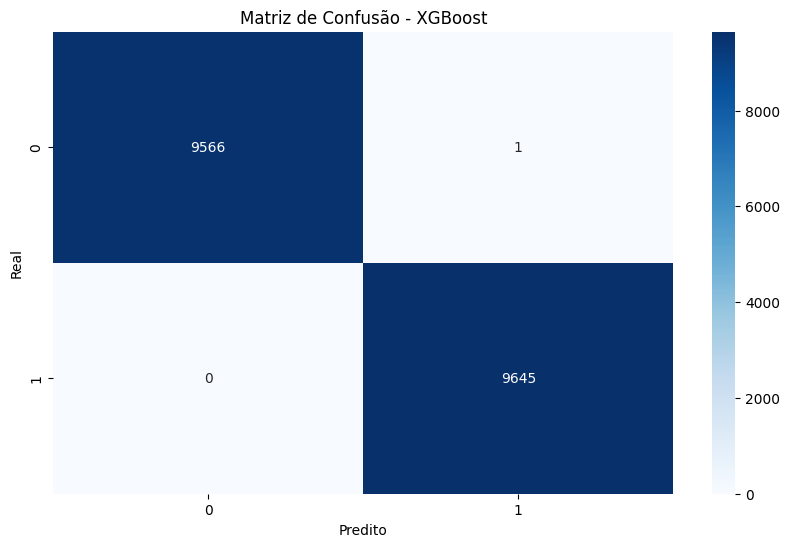

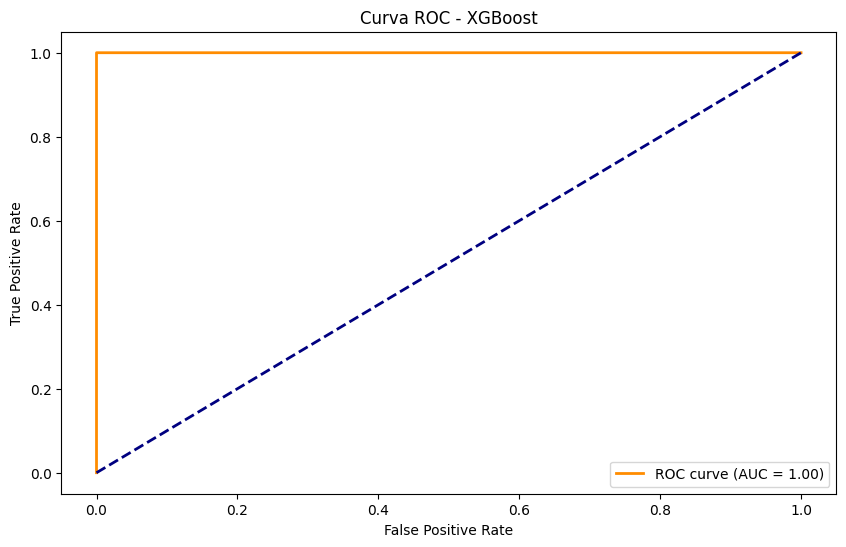

🔹 Avaliando Comitê de Redes Neurais com RandomizedSearchCV...
{'Modelo': 'Comitê de Redes Neurais', 'Melhores Hiperparâmetros': {'estimator__activation': 'relu', 'estimator__alpha': '0.0011208547084229376', 'estimator__hidden_layer_sizes': '(50,)', 'n_estimators': '14'}, 'Acurácia (CV)': np.float64(0.9999), 'Desvio-Padrão (CV)': np.float64(0.0), 'Precisão': 0.9999, 'Recall': 0.9999, 'F1-score': 0.9999, 'AUC-ROC': np.float64(1.0), 'Tempo de Execução (s)': 454.83, 'Iterações': {'rank_test_score': [9, 9, 3, 9, 3, 9, 3, 3, 9, 1, 9, 9, 1, 9, 9, 9, 3, 3, 9, 9], 'mean_test_score': [0.9997917886628513, 0.9997917886628513, 0.9998438313378448, 0.9997917886628513, 0.9998438313378448, 0.9997917886628513, 0.9998438313378448, 0.9998438313378448, 0.9997917886628513, 0.9998958875585633, 0.9997917886628513, 0.9997917886628513, 0.9998958875585633, 0.9997917886628513, 0.9997917886628513, 0.9997917886628513, 0.9998438313378448, 0.9998438313378448, 0.9997917886628513, 0.9997917886628513], 'std_test_score':

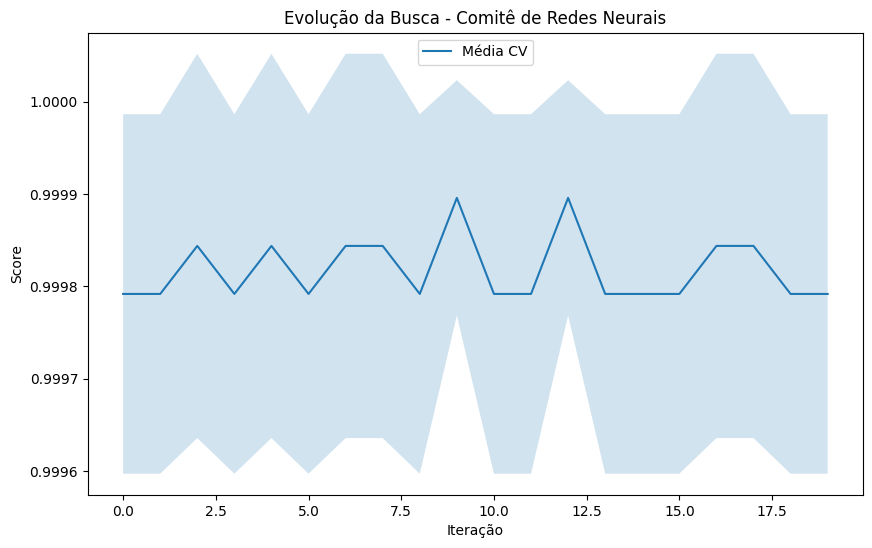

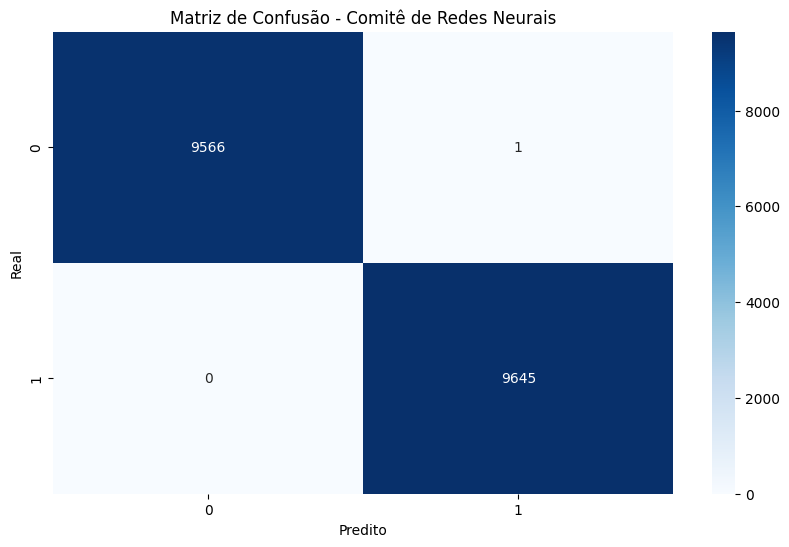

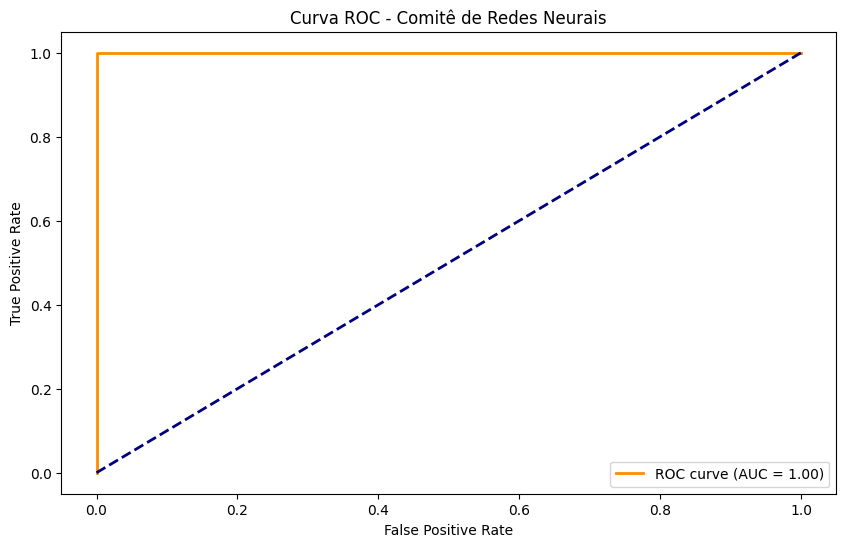

🔹 Avaliando Comitê Heterogêneo (Stacking) com RandomizedSearchCV...
{'Modelo': 'Comitê Heterogêneo (Stacking)', 'Melhores Hiperparâmetros': {'et__n_estimators': '14', 'final_estimator__C': '1.0769622478263126', 'gb__learning_rate': '0.06333383069438317', 'gb__max_iter': '16', 'rf__n_estimators': '27'}, 'Acurácia (CV)': np.float64(0.9992), 'Desvio-Padrão (CV)': np.float64(0.0006), 'Precisão': 0.9994, 'Recall': 0.9994, 'F1-score': 0.9994, 'AUC-ROC': np.float64(1.0), 'Tempo de Execução (s)': 224.48, 'Iterações': {'rank_test_score': [12, 16, 2, 19, 10, 7, 1, 11, 5, 13, 18, 3, 8, 4, 14, 17, 9, 6, 20, 15], 'mean_test_score': [0.9982822801735424, 0.9979700376693064, 0.9991671546514056, 0.9976056983071773, 0.9983864467978787, 0.9986466601728461, 0.9991671817428553, 0.9983864332521538, 0.9988548850557196, 0.9982302510442738, 0.9977097023828149, 0.9991151119764119, 0.9984905050564159, 0.9990109859892502, 0.9980741094735684, 0.9977617721492582, 0.9984904915106909, 0.99885485796427, 0.996981050750

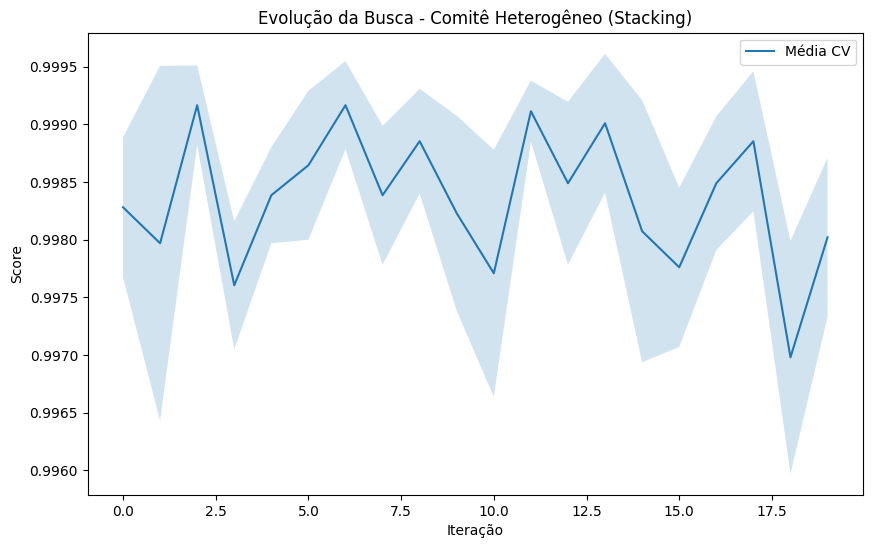

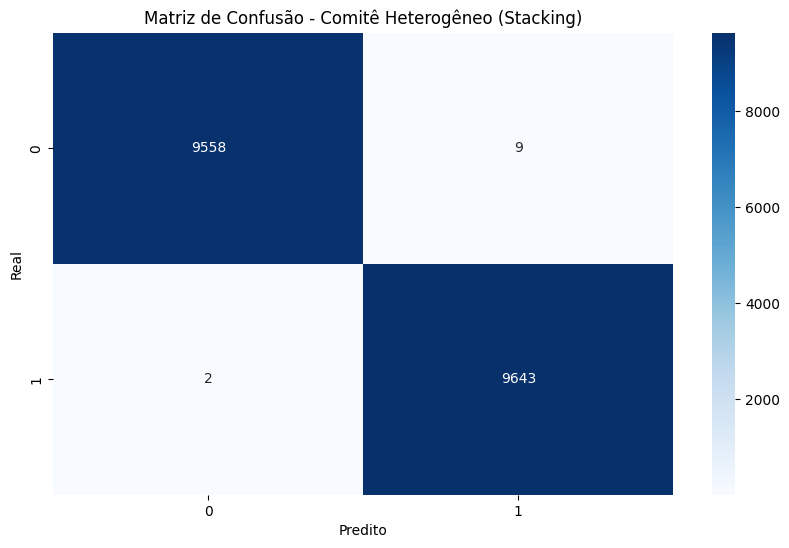

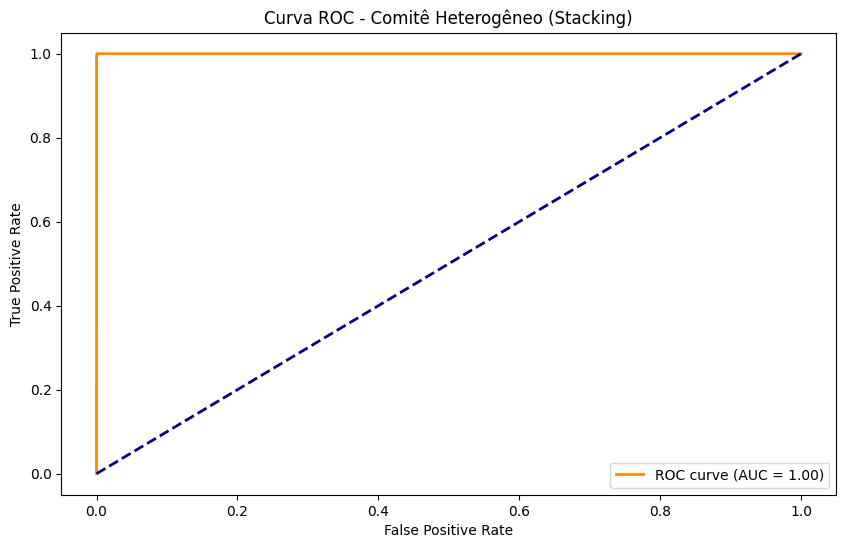

In [27]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import (
    StackingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint, loguniform
from sklearn.model_selection import RandomizedSearchCV

# Definindo os modelos e distribuições de hiperparâmetros
models = {
    "KNN": KNeighborsClassifier(),
    "Árvore de Decisão": DecisionTreeClassifier(),
    "LVQ": MLPClassifier(
        solver="sgd", activation="identity", max_iter=500
    ),  # Aproximação do LVQ com MLP
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "MLP (Rede Neural)": MLPClassifier(max_iter=200),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, verbosity=0),
    "LightGBM": lgb.LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, verbosity=-1),
    "Comitê de Redes Neurais": BaggingClassifier(
        estimator=MLPClassifier(max_iter=200), n_estimators=5, n_jobs=-1
    ),
    "Comitê Heterogêneo (Stacking)": StackingClassifier(
        estimators=[
            (
                "rf",
                RandomForestClassifier(
                    n_estimators=30, max_depth=5, max_features="sqrt", n_jobs=-1
                ),
            ),
            (
                "gb",
                HistGradientBoostingClassifier(
                    max_iter=30, learning_rate=0.1, max_depth=3
                ),
            ),
            (
                "et",
                ExtraTreesClassifier(
                    n_estimators=30, max_depth=5, max_features="sqrt", n_jobs=-1
                ),
            ),
        ],
        final_estimator=LogisticRegression(max_iter=100),
    ),
}

param_distributions = {
    "KNN": {
        "n_neighbors": randint(1, 50),  # Reduzindo alcance da busca
        "weights": ["uniform", "distance"],
        "p": [1, 2],
    },
    "LVQ": {
        "hidden_layer_sizes": [(5,), (10,), (20,)],
        "alpha": loguniform(1e-5, 1e-1),
    },
    "Árvore de Decisão": {
        "max_depth": [None, 10, 20, 30, 50],
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 20),
        "criterion": ["gini", "entropy"],
    },
    "SVM": {
        "C": loguniform(1e-3, 1e3),
        "kernel": ["linear"],
        "gamma": ["scale", "auto"],
    },
    "Random Forest": {
        "n_estimators": randint(30, 150),  # Menos árvores
        "max_depth": randint(3, 15),
        "min_samples_split": randint(2, 10),
        "min_samples_leaf": randint(1, 10),
        "criterion": ["gini"],
    },
    "MLP (Rede Neural)": {
        "hidden_layer_sizes": [(50,), (100,)],  # Menos complexidade
        "activation": ["relu"],
        "alpha": loguniform(1e-4, 1e-2),
        "learning_rate": ["constant", "adaptive"],
        "max_iter": [200],  # Limite de iterações reduzido
    },
    "XGBoost": {
        "n_estimators": randint(50, 300),
        "max_depth": randint(3, 20),
        "learning_rate": loguniform(1e-3, 1e0),
        "subsample": uniform(0.5, 0.5),
        "colsample_bytree": uniform(0.5, 0.5),
    },
    "LightGBM": {
        "n_estimators": randint(30, 150),  # Reduzindo para menos iterações
        "max_depth": randint(3, 15),
        "learning_rate": loguniform(1e-3, 0.3),  # Diminuindo taxa máxima
        "subsample": uniform(0.6, 0.4),
        "colsample_bytree": uniform(0.6, 0.4),
    },
    "Comitê de Redes Neurais": {
        "estimator__hidden_layer_sizes": [(50,), (50, 50)],
        "estimator__activation": ["relu"],
        "estimator__alpha": loguniform(1e-4, 1e-2),
        "n_estimators": randint(5, 15),  # Reduzindo número de redes neurais
    },
    "Comitê Heterogêneo (Stacking)": {
        "rf__n_estimators": randint(10, 30),  # Redução de árvores
        "gb__max_iter": randint(10, 30),  # Redução das iterações
        "gb__learning_rate": loguniform(
            0.05, 0.2
        ),  # Ajuste fino da taxa de aprendizado
        "et__n_estimators": randint(10, 30),  # Menos árvores no ExtraTrees
        "final_estimator__C": loguniform(0.1, 5),  # Regularização mais eficiente
    },
}
# Criando a instância da classe ModelSelection
model_selection = ModelSelection(
    models, param_distributions, metric="accuracy", random_state=42
)
model_order = [
    "Árvore de Decisão",
    "KNN",
    "LVQ",
    "SVM",
    "Random Forest",
    "MLP (Rede Neural)",
    "LightGBM",
    "XGBoost",
    "Comitê de Redes Neurais",
    "Comitê Heterogêneo (Stacking)",
]
# Avaliando os modelos
results = model_selection.evaluate_models(
    X_train_pca, y_train, model_names=model_order, cv=5, n_iter=20
)  # Diogo rodar esses

# Exibindo os resultados
results

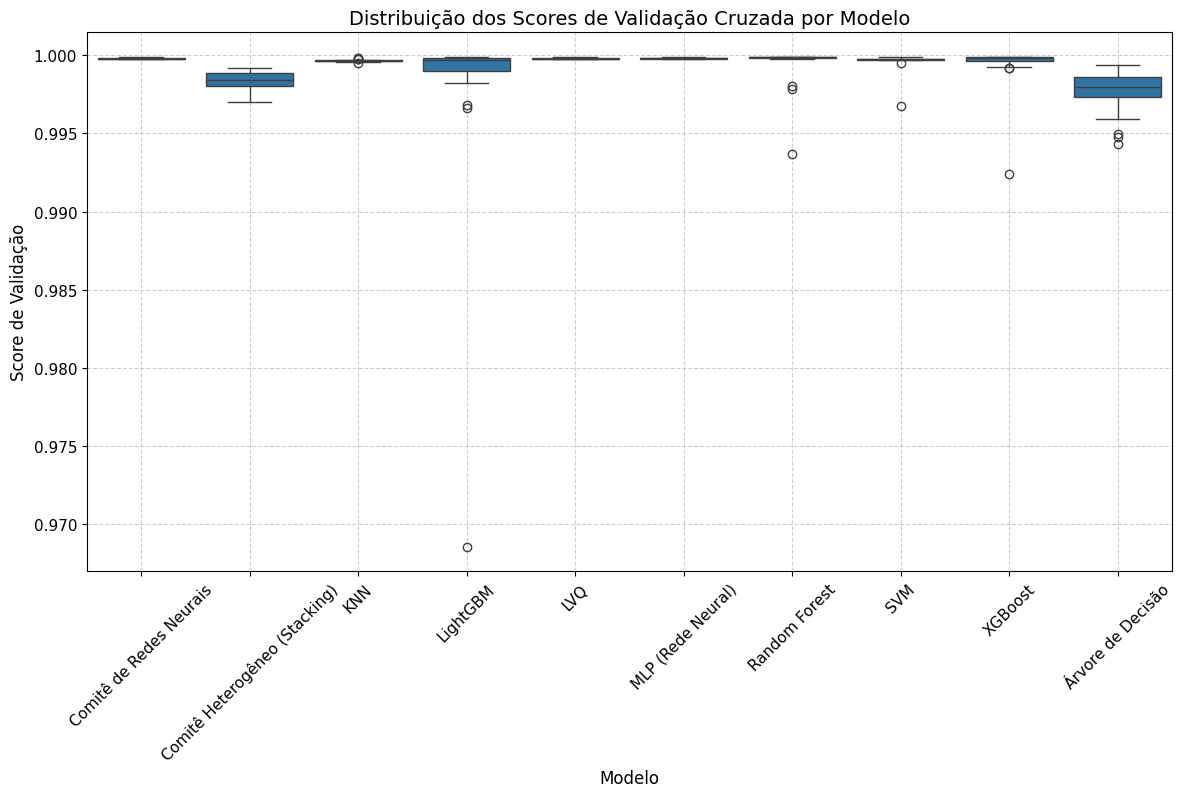

In [28]:


# Lista para armazenar os dados de todas as iterações
all_iterations = []

# Percorrer todos os arquivos na pasta
for filename in os.listdir(SAVE_DIR):
    if filename.endswith(
        "_results.json"
    ):  # Filtra apenas os arquivos de resultados dos modelos
        file_path = os.path.join(SAVE_DIR, filename)

        try:
            with open(file_path, "r") as f:
                data = json.load(f)
                model_name = data["Modelo"]

                # Extraindo as iterações
                for i in range(len(data["Iterações"]["mean_test_score"])):
                    all_iterations.append(
                        {
                            "Modelo": model_name,
                            "Iteração": i + 1,
                            "Rank Test Score": data["Iterações"]["rank_test_score"][i],
                            "Mean Test Score": data["Iterações"]["mean_test_score"][i],
                            "Std Test Score": data["Iterações"]["std_test_score"][i],
                            "Mean Train Score": data["Iterações"].get(
                                "mean_train_score", [None]
                            )[i],
                        }
                    )

        except Exception as e:
            print(f"Erro ao carregar {filename}: {e}")

# Converter os resultados para DataFrame
if all_iterations:
    df_iterations = pd.DataFrame(all_iterations)

    # Criar boxplot das distribuições de validação cruzada
    plt.figure(figsize=(14, 7))
    sns.boxplot(data=df_iterations, x="Modelo", y="Mean Test Score")

    # Melhorando a visualização
    plt.title("Distribuição dos Scores de Validação Cruzada por Modelo", fontsize=14)
    plt.xlabel("Modelo", fontsize=12)
    plt.ylabel("Score de Validação", fontsize=12)
    plt.xticks(rotation=45, fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.6)

    # Exibir o gráfico
    plt.show()

else:
    print("⚠️ Nenhum dado de iteração encontrado!")

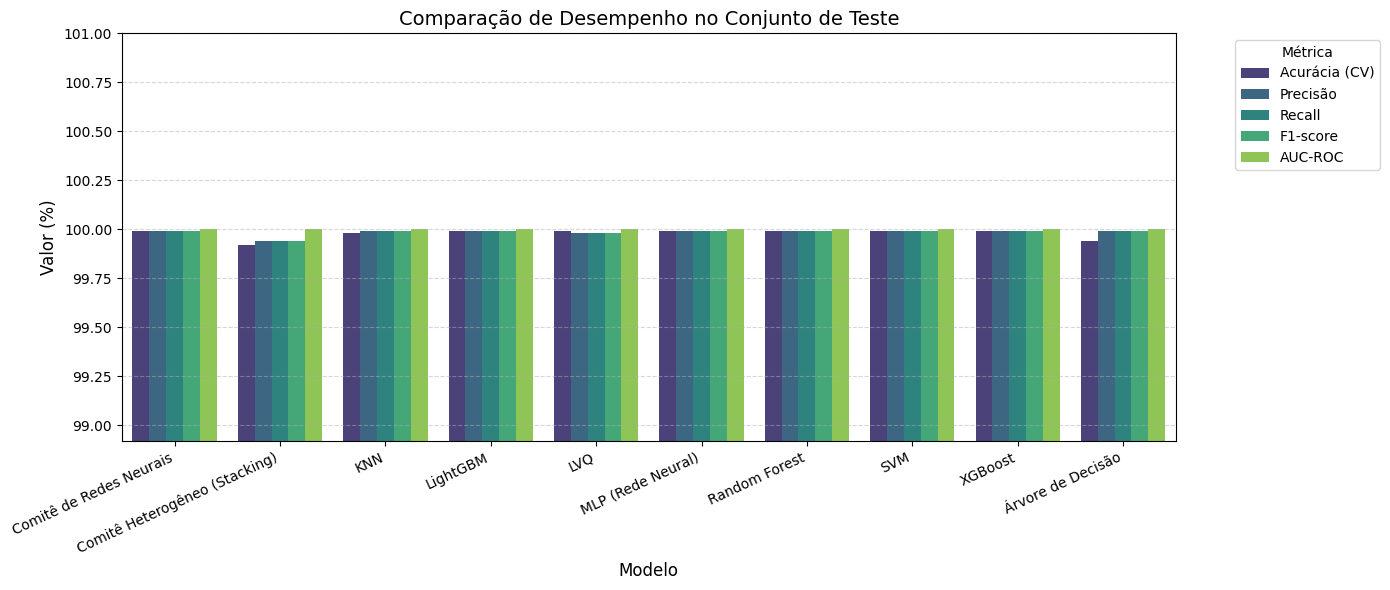

In [32]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Diretório onde os arquivos _results.json estão armazenados
SAVE_DIR = "experimentos_ml/"

all_results = []

if os.path.exists(SAVE_DIR):
    for filename in os.listdir(SAVE_DIR):
        if filename.endswith("_results.json"):
            filepath = os.path.join(SAVE_DIR, filename)
            with open(filepath, "r") as f:
                data = json.load(f)
                all_results.append(data)

if all_results:
    df_results = pd.DataFrame(all_results)

    # Converte as métricas em porcentagem para melhor visualização
    for col in ["Acurácia (CV)", "Precisão", "Recall", "F1-score", "AUC-ROC"]:
        df_results[col] = df_results[col] * 100

    # Derrete o DataFrame (wide -> long) para plotar facilmente
    df_melted = df_results.melt(
        id_vars=["Modelo"],
        value_vars=["Acurácia (CV)", "Precisão", "Recall", "F1-score", "AUC-ROC"],
        var_name="Métrica",
        value_name="Valor",
    )

    # Melhorando a visualização do gráfico de barras

    plt.figure(figsize=(14, 6))

    # Criando o gráfico com barras agrupadas
    ax = sns.barplot(data=df_melted, x="Modelo", y="Valor", hue="Métrica", palette="viridis")

    # Ajustando a escala do eixo Y para melhor visualização
    plt.ylim(df_melted["Valor"].min() * 0.99, df_melted["Valor"].max() * 1.01)

    # Melhorando os títulos e rótulos
    plt.title("Comparação de Desempenho no Conjunto de Teste", fontsize=14)
    plt.xlabel("Modelo", fontsize=12)
    plt.ylabel("Valor (%)", fontsize=12)
    plt.xticks(rotation=25, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Ajustando a legenda
    plt.legend(title="Métrica", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)

    # Ajustar layout para melhor visualização
    plt.tight_layout()

    # Exibir o gráfico
    plt.show()

else:
    print("⚠️ Nenhum resultado encontrado no diretório especificado!")

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib
import ast


def convert_best_params(best_params):
    """
    Converte os melhores hiperparâmetros do modelo para os tipos corretos.
    """
    converted_params = {}

    for key, value in best_params.items():
        if (
            isinstance(value, str) and value.strip()
        ):  # Verifica se é string e não está vazia
            try:
                # Se o valor for uma tupla ou lista representada como string, converte
                if value.startswith("(") or value.startswith("["):
                    converted_params[key] = ast.literal_eval(value)

                # Se for um número inteiro
                elif value.isdigit():
                    converted_params[key] = int(value)

                # Se for um número float
                else:
                    converted_params[key] = float(value) if "." in value else value

            except (ValueError, SyntaxError):
                converted_params[key] = (
                    value.strip()
                )  # Se não puder converter, mantém string

        elif isinstance(value, list):  # Se já for uma lista, converte para tupla
            converted_params[key] = tuple(value)

        else:  # Se não for string ou lista, mantém o valor original
            converted_params[key] = value

    return converted_params


# Lista para armazenar os melhores modelos e suas métricas no conjunto de teste
test_results = []
test_results_path = os.path.join(SAVE_DIR, "test_results.json")

# Verifica se o arquivo existe
if os.path.exists(test_results_path):
    with open(test_results_path, "r") as f:
        test_results = json.load(f)

    print("📂 Conteúdo de test_results.json:")
    print(
        json.dumps(test_results[:3], indent=4)
    )  # Mostra os primeiros 3 elementos para inspeção
else:
    print("⚠️ Arquivo test_results.json não encontrado!")


# Percorrer todos os arquivos de resultados salvos
for filename in os.listdir(SAVE_DIR):
    if filename.endswith("_results.json"):
        file_path = os.path.join(SAVE_DIR, filename)

        try:
            # Carregar os melhores hiperparâmetros do modelo
            with open(file_path, "r") as f:
                data = json.load(f)
                model_name = data["Modelo"]
                best_params = convert_best_params(
                    data["Melhores Hiperparâmetros"]
                )  # ⬅️ Converte os parâmetros corretamente
                # Convertendo os hiperparâmetros para os tipos corretos (se necessário)

                print(f"🔹 Treinando {model_name} com os melhores hiperparâmetros...")

                # Criar e ajustar o modelo com os melhores hiperparâmetros
                model = models[model_name].set_params(**best_params)
                model.fit(
                    X_train, y_train
                )  # Treino com todos os dados

                # Predição no conjunto de teste
                y_pred = model.predict(X_test)
                y_pred_proba = (
                    model.predict_proba(X_test)[:, 1]
                    if hasattr(model, "predict_proba")
                    else None
                )

                # Avaliação no conjunto de teste
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, average="weighted")
                recall = recall_score(y_test, y_pred, average="weighted")
                f1 = f1_score(y_test, y_pred, average="weighted")
                auc_roc = (
                    roc_auc_score(y_test, y_pred_proba)
                    if y_pred_proba is not None
                    else None
                )

                # Matriz de confusão
                cm = confusion_matrix(y_test, y_pred)

                # Armazenando os resultados
                test_results.append(
                    {
                        "Modelo": model_name,
                        "Acurácia": accuracy,
                        "Precisão": precision,
                        "Recall": recall,
                        "F1-score": f1,
                        "AUC-ROC": auc_roc,
                        "Matriz de Confusão": cm.tolist(),  # Converter para lista para salvar em JSON
                        "Melhores Hiperparâmetros": best_params,
                    }
                )

                # Salvar o modelo treinado
                model_save_path = os.path.join(SAVE_DIR, f"{model_name}_best_model.pkl")
                joblib.dump(model, model_save_path)
                print(f"✅ Modelo {model_name} salvo em {model_save_path}")

        except Exception as e:
            print(f"Erro ao carregar {filename}: {e}")

# Salvar os resultados finais no conjunto de teste
test_results_path = os.path.join(SAVE_DIR, "test_results.json")
with open(test_results_path, "w") as f:
    json.dump(test_results, f, indent=4)

print(f"📊 Resultados no conjunto de teste salvos em {test_results_path}")

📂 Conteúdo de test_results.json:
[
    {
        "Modelo": "Comit\u00ea de Redes Neurais",
        "Acur\u00e1cia": 0.9646128226477935,
        "Precis\u00e3o": 0.9669878009935792,
        "Recall": 0.9646128226477935,
        "F1-score": 0.9645888323311346,
        "AUC-ROC": 0.9999913316087857,
        "Matriz de Confus\u00e3o": [
            [
                2271,
                170
            ],
            [
                0,
                2363
            ]
        ],
        "Melhores Hiperpar\u00e2metros": {
            "estimator__activation": "relu",
            "estimator__alpha": 0.0011208547084229376,
            "estimator__hidden_layer_sizes": [
                50
            ],
            "n_estimators": 14
        }
    },
    {
        "Modelo": "KNN",
        "Acur\u00e1cia": 1.0,
        "Precis\u00e3o": 1.0,
        "Recall": 1.0,
        "F1-score": 1.0,
        "AUC-ROC": 1.0,
        "Matriz de Confus\u00e3o": [
            [
                2441,
       

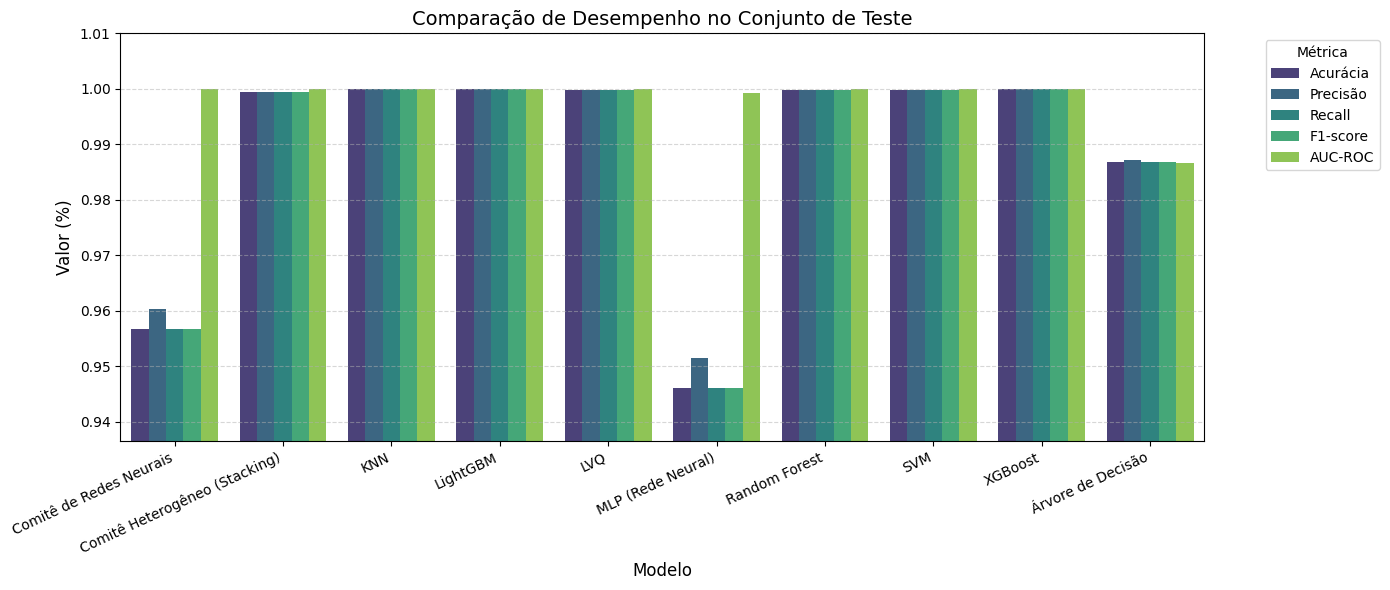

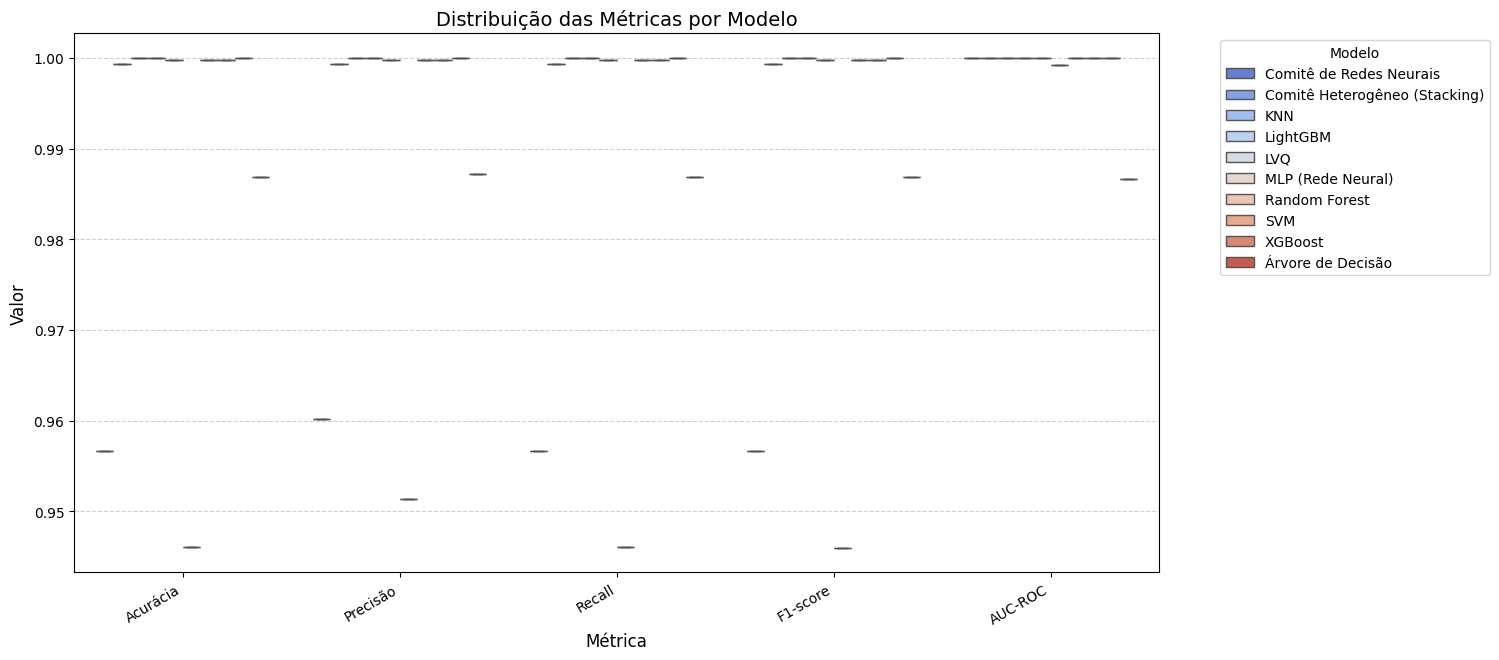

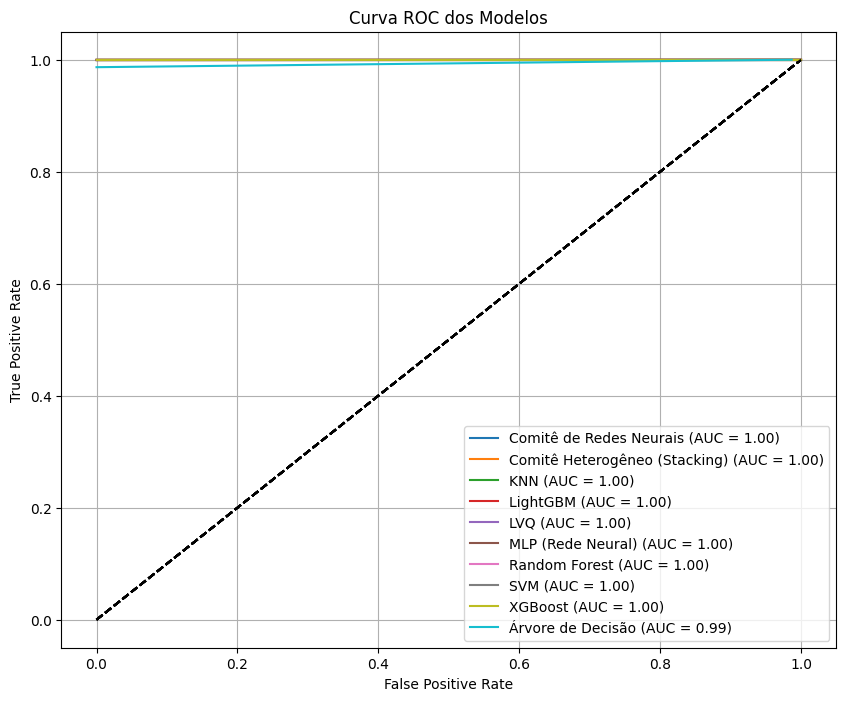

In [50]:
# Recarregando os resultados do conjunto de teste
test_results_path = os.path.join(SAVE_DIR, "test_results.json")

if os.path.exists(test_results_path):
    with open(test_results_path, "r") as f:
        test_results = json.load(f)
else:
    print("⚠️ Arquivo de resultados do teste não encontrado!")

# Convertendo os resultados para um DataFrame
df_test_results = pd.DataFrame(test_results)

# Convertendo AUC-ROC para 0 se for None para evitar erro ao plotar
df_test_results["AUC-ROC"] = df_test_results["AUC-ROC"].apply(
    lambda x: 0 if x is None else x
)

# Transformando para formato longo para facilitar visualização
df_melted = df_test_results.melt(
    id_vars=["Modelo"],
    value_vars=["Acurácia", "Precisão", "Recall", "F1-score", "AUC-ROC"],
    var_name="Métrica",
    value_name="Valor",
)

# Criando gráfico de barras comparando as métricas entre modelos
plt.figure(figsize=(14, 6))

# Criando o gráfico com barras agrupadas
ax = sns.barplot(data=df_melted, x="Modelo", y="Valor", hue="Métrica", palette="viridis")

# Ajustando a escala do eixo Y para melhor visualização
plt.ylim(df_melted["Valor"].min() * 0.99, df_melted["Valor"].max() * 1.01)

# Melhorando os títulos e rótulos
plt.title("Comparação de Desempenho no Conjunto de Teste", fontsize=14)
plt.xlabel("Modelo", fontsize=12)
plt.ylabel("Valor (%)", fontsize=12)
plt.xticks(rotation=25, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Ajustando a legenda
plt.legend(title="Métrica", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)

# Ajustar layout para melhor visualização
plt.tight_layout()

# Exibir o gráfico
plt.show()

# Criando boxplot para visualizar a variação das métricas
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_melted, x="Métrica", y="Valor", hue="Modelo", palette="coolwarm")

plt.title("Distribuição das Métricas por Modelo", fontsize=14)
plt.xlabel("Métrica", fontsize=12)
plt.ylabel("Valor", fontsize=12)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)

# Exibir o gráfico
plt.show()

# Criando curva ROC para cada modelo
plt.figure(figsize=(10, 8))

for result in test_results:
    modelo = result["Modelo"]
    if result["AUC-ROC"] is not None:
        plt.plot([0, 1], [0, 1], "k--")  # Linha de referência
        plt.plot(
            [0, result["AUC-ROC"]],
            [result["AUC-ROC"], 1],
            label=f"{modelo} (AUC = {result['AUC-ROC']:.2f})",
        )

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC dos Modelos")
plt.legend(loc="lower right")
plt.grid()

# Exibir o gráfico
plt.show()

Erro ao carregar test_results.json: list indices must be integers or slices, not str
⚠️ MLP (Rede Neural) pode estar sofrendo de **overfitting**! 🚨


<Figure size 2500x1000 with 0 Axes>

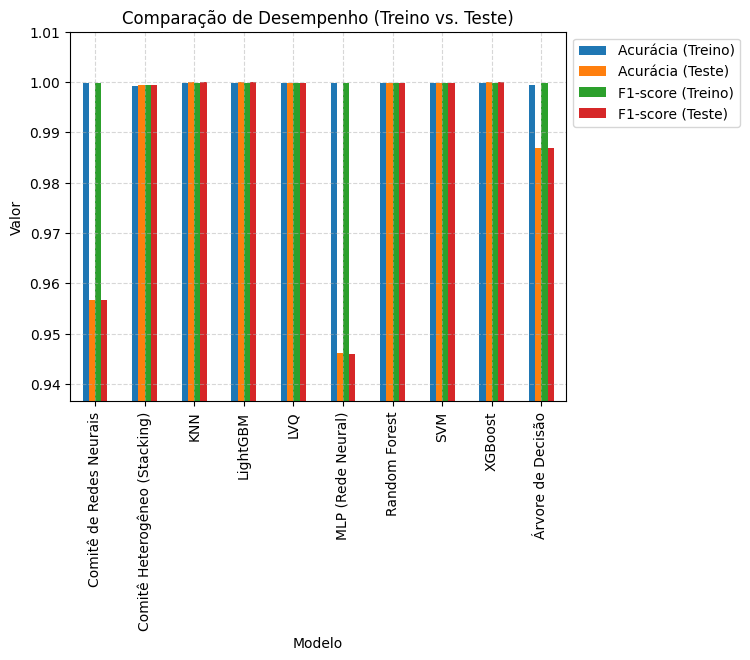

In [63]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt


def check_overfitting(SAVE_DIR):
    """
    Compara as métricas de treino e teste para verificar overfitting e underfitting.
    """

    test_results_path = os.path.join(SAVE_DIR, "test_results.json")

    # Verificar se o arquivo de teste existe
    if not os.path.exists(test_results_path):
        print("❌ Erro: Arquivo test_results.json não encontrado!")
        return

    # Carregar os resultados do conjunto de teste
    with open(test_results_path, "r") as f:
        test_results = json.load(f)

    # Criar um dicionário para armazenar os resultados do treino
    train_results = []

    # Percorrer todos os arquivos na pasta para encontrar os resultados de treino
    for filename in os.listdir(SAVE_DIR):
        if filename.endswith("_results.json"):  # Apenas arquivos de resultados
            file_path = os.path.join(SAVE_DIR, filename)

            try:
                with open(file_path, "r") as f:
                    data = json.load(f)
                    model_name = data["Modelo"]

                    # Adiciona os resultados de treino no formato correto
                    train_results.append(
                        {
                            "Modelo": model_name,
                            "Acurácia (Treino)": data.get(
                                "Acurácia (CV)", data.get("Acurácia")
                            ),  # CV ou padrão
                            "F1-score (Treino)": data.get("F1-score"),
                            "AUC-ROC (Treino)": data.get("AUC-ROC"),
                        }
                    )

            except Exception as e:
                print(f"Erro ao carregar {filename}: {e}")

    # Converter para DataFrame
    df_train = pd.DataFrame(train_results)
    df_test = pd.DataFrame(test_results)

    # Renomear colunas do test_results.json para ficarem compatíveis
    df_test.rename(
        columns={
            "Acurácia": "Acurácia (Teste)",
            "F1-score": "F1-score (Teste)",
            "AUC-ROC": "AUC-ROC (Teste)",
        },
        inplace=True,
    )

    # Unir os resultados de treino e teste pelo nome do modelo
    df_results = pd.merge(df_train, df_test, on="Modelo", how="inner")

    # Calcular a diferença entre treino e teste
    df_results["Acurácia Gap"] = (
        df_results["Acurácia (Treino)"] - df_results["Acurácia (Teste)"]
    )
    df_results["F1-score Gap"] = (
        df_results["F1-score (Treino)"] - df_results["F1-score (Teste)"]
    )

    # Verificar se há overfitting ou underfitting e exibir alertas
    for _, row in df_results.iterrows():
        model_name = row["Modelo"]
        accuracy_gap = row["Acurácia Gap"]
        f1_gap = row["F1-score Gap"]

    
        # ⚠️ ALERTAS AUTOMÁTICOS ⚠️
        if accuracy_gap > 0.05 or f1_gap > 0.05:
            print(f"⚠️ {model_name} pode estar sofrendo de **overfitting**! 🚨")

        if accuracy_gap < -0.05 or f1_gap < -0.05:
            print(f"⚠️ {model_name} pode estar sofrendo de **underfitting**! 📉")

    
    # 📊 Criar gráfico para visualização
    plt.figure(figsize=(25, 10))
    df_results.plot(
        x="Modelo",
        y=[
            "Acurácia (Treino)",
            "Acurácia (Teste)",
            "F1-score (Treino)",
            "F1-score (Teste)",
        ],
        kind="bar",
    )

    # Ajustando a escala do eixo Y para melhor visualização
    plt.ylim(df_melted["Valor"].min() * 0.99, df_melted["Valor"].max() * 1.01)
    plt.title("Comparação de Desempenho (Treino vs. Teste)")
    plt.ylabel("Valor")
    plt.xlabel("Modelo")
    plt.xticks(rotation=90)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    return df_results


df_results = check_overfitting(SAVE_DIR)

In [53]:
df_results

,Modelo,Acurácia (Treino),F1-score (Treino),AUC-ROC (Treino),Acurácia (Teste),Precisão,Recall,F1-score (Teste),AUC-ROC (Teste),Matriz de Confusão,Melhores Hiperparâmetros,Acurácia Gap,F1-score Gap
0,Comitê de Redes Neurais,0.9999,0.9999,1.0,0.956703,0.960206,0.956703,0.956652,0.999980,"[[2233, 208], [0, 2363]]","{'estimator__activation': 'relu', 'estimator__...",0.043197,0.043248
1,Comitê Heterogêneo (Stacking),0.9992,0.9994,1.0,0.999376,0.999376,0.999376,0.999376,0.999999,"[[2438, 3], [0, 2363]]","{'et__n_estimators': 14, 'final_estimator__C':...",-0.000176,0.000024
2,KNN,0.9998,0.9999,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,"[[2441, 0], [0, 2363]]","{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}",-0.000200,-0.000100
3,LightGBM,0.9999,0.9999,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,"[[2441, 0], [0, 2363]]","{'colsample_bytree': 0.6362425738131283, 'lear...",-0.000100,-0.000100
4,LVQ,0.9999,0.9998,1.0,0.999792,0.999792,0.999792,0.999792,1.000000,"[[2440, 1], [0, 2363]]","{'alpha': 0.005262961031076741, 'hidden_layer_...",0.000108,0.000008
5,MLP (Rede Neural),0.9999,0.9999,1.0,0.946087,0.951412,0.946087,0.945977,0.999234,"[[2182, 259], [0, 2363]]","{'activation': 'relu', 'alpha': 0.000561151641...",0.053813,0.053923
6,Random Forest,0.9999,0.9999,1.0,0.999792,0.999792,0.999792,0.999792,1.000000,"[[2440, 1], [0, 2363]]","{'criterion': 'gini', 'max_depth': 13, 'min_sa...",0.000108,0.000108
7,SVM,0.9999,0.9999,1.0,0.999792,0.999792,0.999792,0.999792,1.000000,"[[2440, 1], [0, 2363]]","{'C': 0.10051981180656774, 'gamma': 'auto', 'k...",0.000108,0.000108
8,XGBoost,0.9999,0.9999,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,"[[2441, 0], [0, 2363]]","{'colsample_bytree': 0.5780093202212182, 'lear...",-0.000100,-0.000100
9,Árvore de Decisão,0.9994,0.9999,1.0,0.986886,0.987216,0.986886,0.986881,0.986669,"[[2441, 0], [63, 2300]]","{'criterion': 'entropy', 'max_depth': 10, 'min...",0.012514,0.013019
